### Dependencias

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from sklearn.model_selection import train_test_split


SEED= 1234

### Carga de datos

In [36]:
df = pd.read_csv('./data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [38]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# Problema de regresion

In [39]:
df_regresion = df.copy()

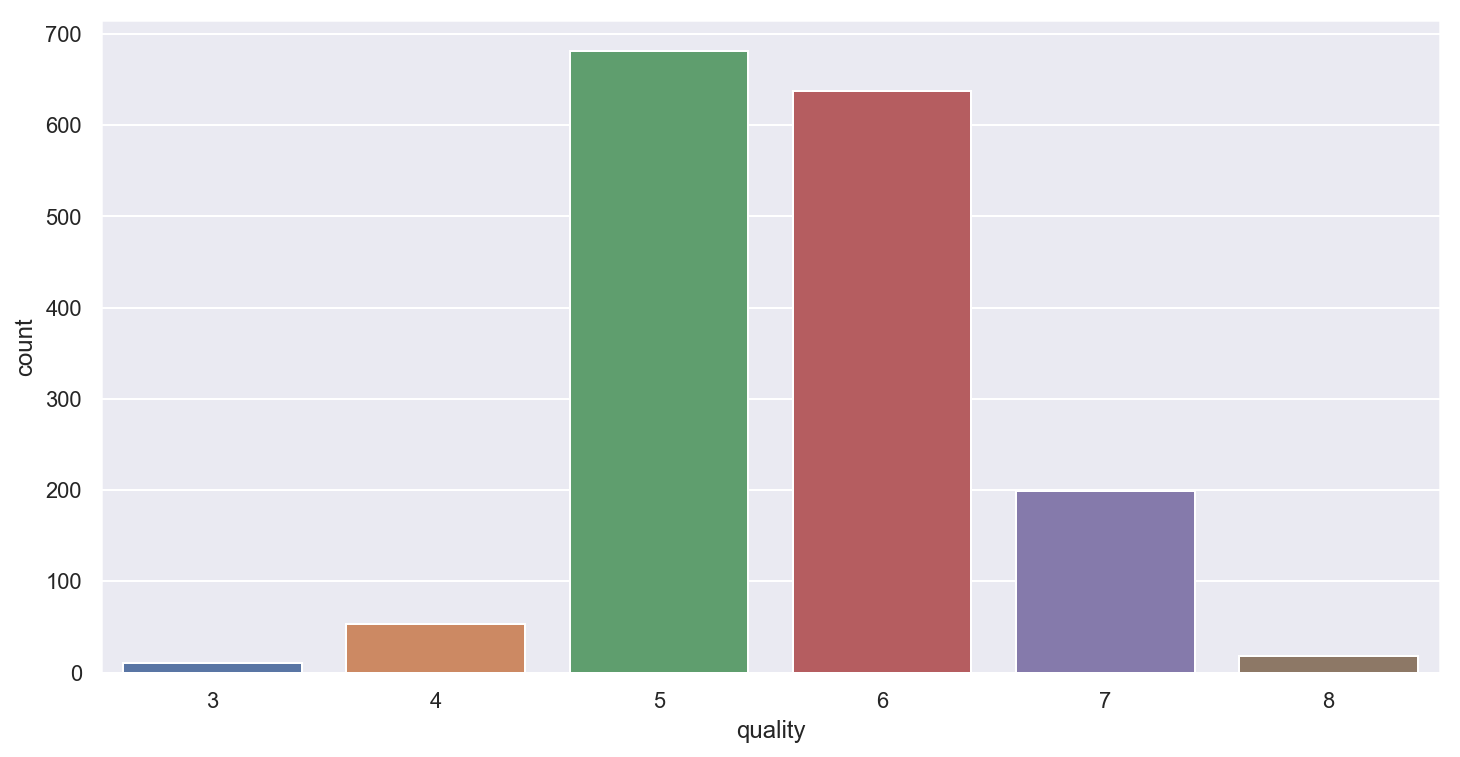

In [40]:
plt.figure(figsize=(12,6))
sns.countplot(df_regresion['quality'])
plt.show()

In [41]:
X = df_regresion.drop(columns=['quality']).copy()
y = df_regresion['quality'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train
df_modelar['quality'] = y_train
df_modelar_new = X_val
df_modelar_new['quality'] = y_val

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  1359
Tamaño del conjunto de nuevos datos:  240


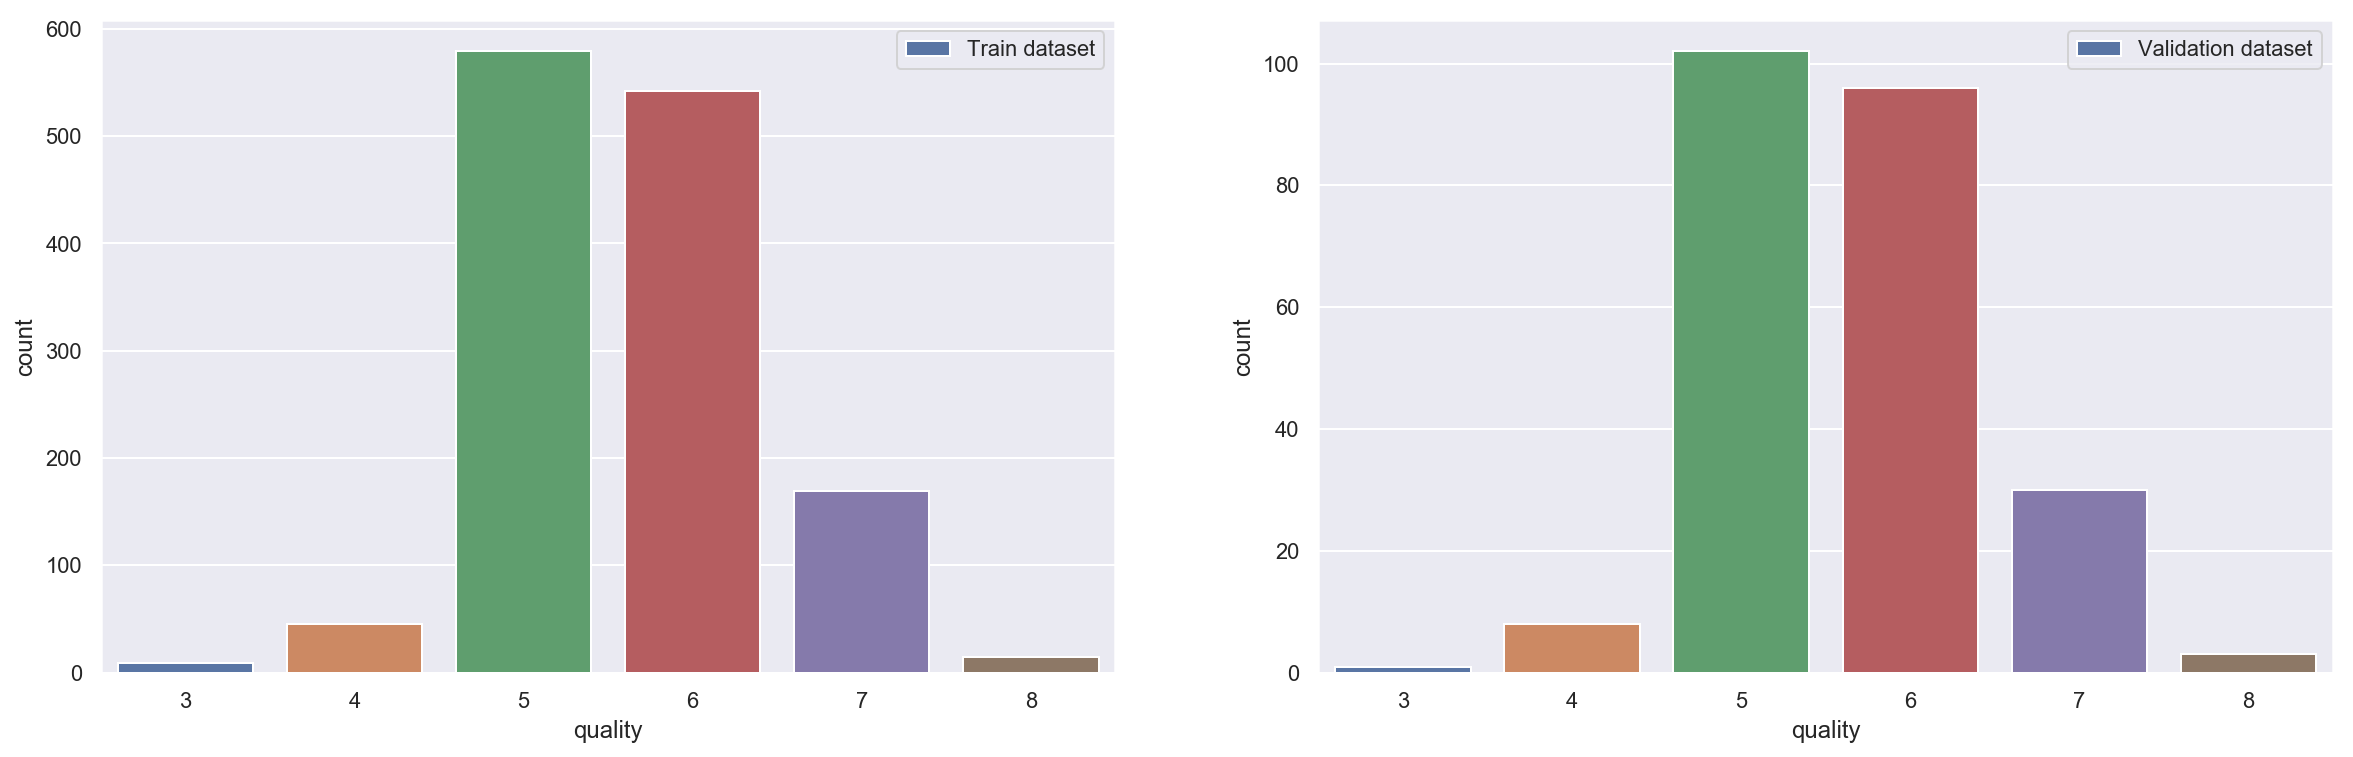

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sns.countplot(df_modelar['quality'], label='Train dataset', ax=ax1)
sns.countplot(df_modelar_new['quality'], label='Validation dataset', ax=ax2)
ax1.legend()
ax2.legend()
plt.show()

In [43]:
# Correlación perteneciente a las variables menos la variable objetivo
df_modelar[df_modelar.columns[:-1]].corr().style.background_gradient()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1,-0.255643,0.675687,0.129468,0.0903588,-0.146324,-0.105819,0.662871,-0.680902,0.195905,-0.0569139
volatile acidity,-0.255643,1,-0.558962,0.0137311,0.0708331,0.00799566,0.0883648,0.0300534,0.233931,-0.255736,-0.211103
citric acid,0.675687,-0.558962,1,0.140524,0.194713,-0.0689812,0.03094,0.367248,-0.544939,0.31409,0.104924
residual sugar,0.129468,0.0137311,0.140524,1,0.0657086,0.164144,0.188966,0.373295,-0.0984569,0.0159729,0.0270197
chlorides,0.0903588,0.0708331,0.194713,0.0657086,1,0.00965827,0.0510003,0.202485,-0.265449,0.388869,-0.229812
free sulfur dioxide,-0.146324,0.00799566,-0.0689812,0.164144,0.00965827,1,0.666864,-0.0287343,0.0657509,0.0406197,-0.0662082
total sulfur dioxide,-0.105819,0.0883648,0.03094,0.188966,0.0510003,0.666864,1,0.0654651,-0.0673853,0.014285,-0.203639
density,0.662871,0.0300534,0.367248,0.373295,0.202485,-0.0287343,0.0654651,1,-0.327129,0.164798,-0.489927
pH,-0.680902,0.233931,-0.544939,-0.0984569,-0.265449,0.0657509,-0.0673853,-0.327129,1,-0.17694,0.203057
sulphates,0.195905,-0.255736,0.31409,0.0159729,0.388869,0.0406197,0.014285,0.164798,-0.17694,1,0.094674


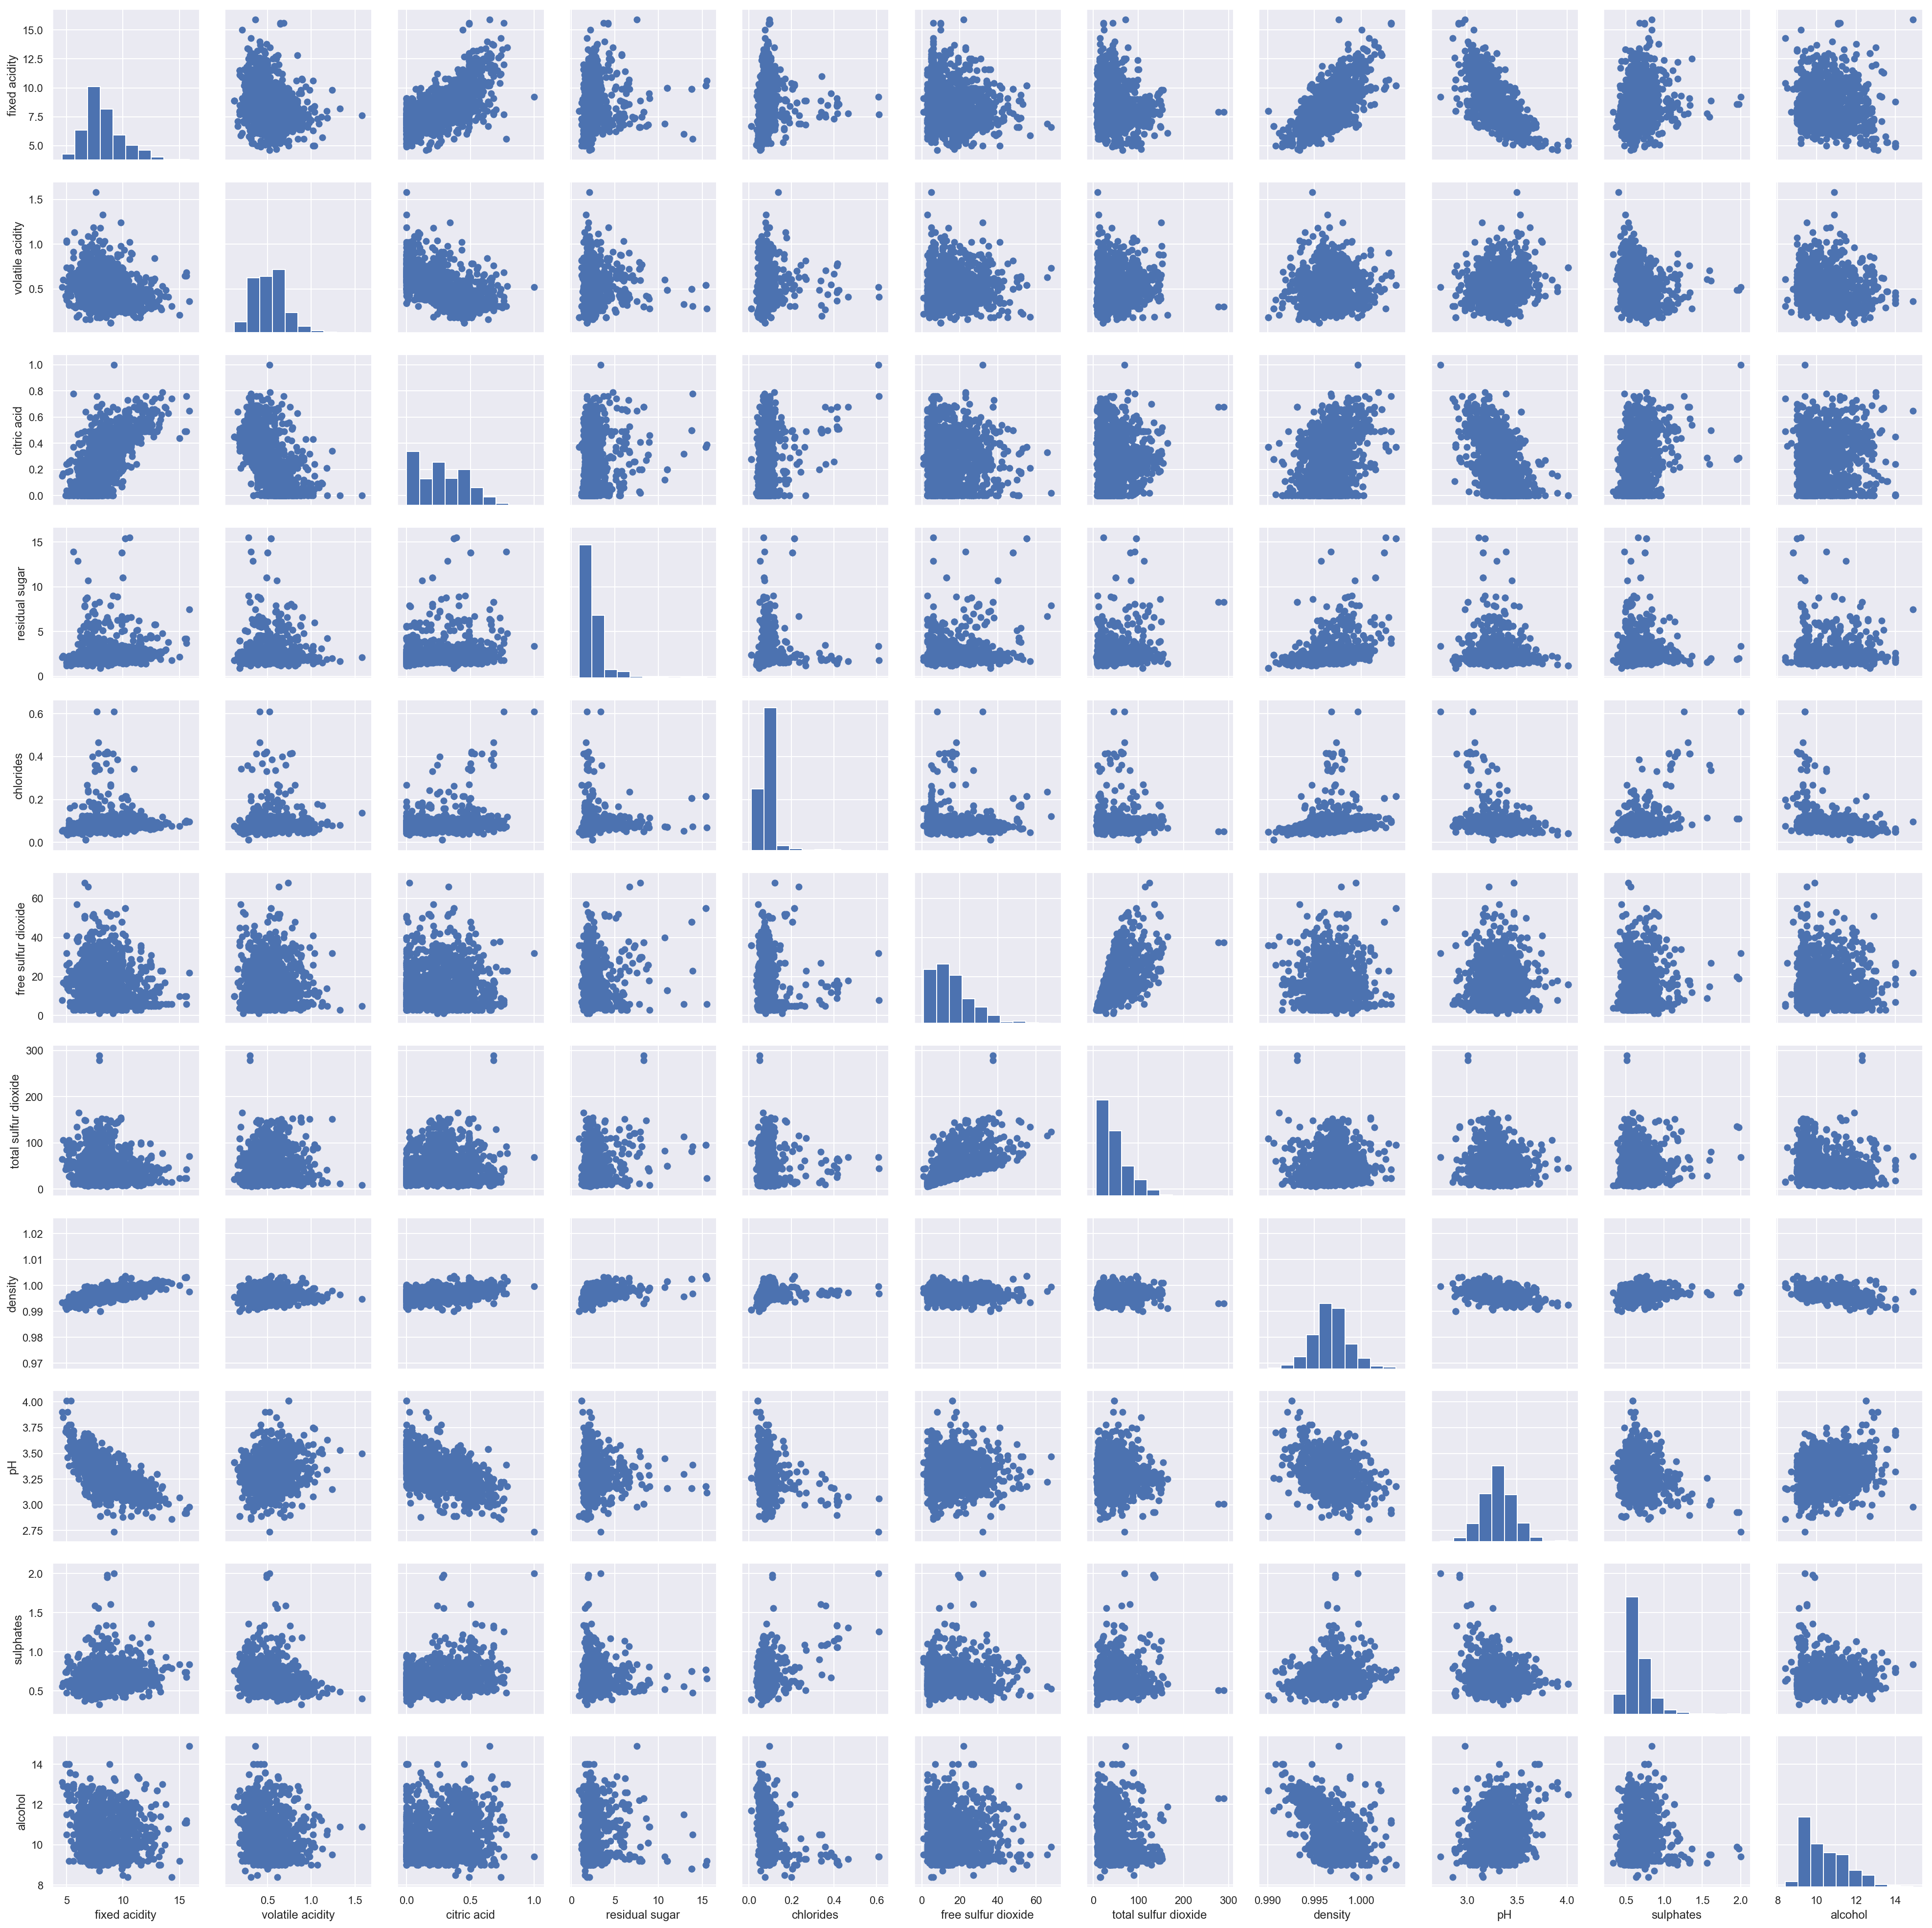

In [44]:
g = sns.PairGrid(df_modelar[df_modelar.columns[:-1]])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

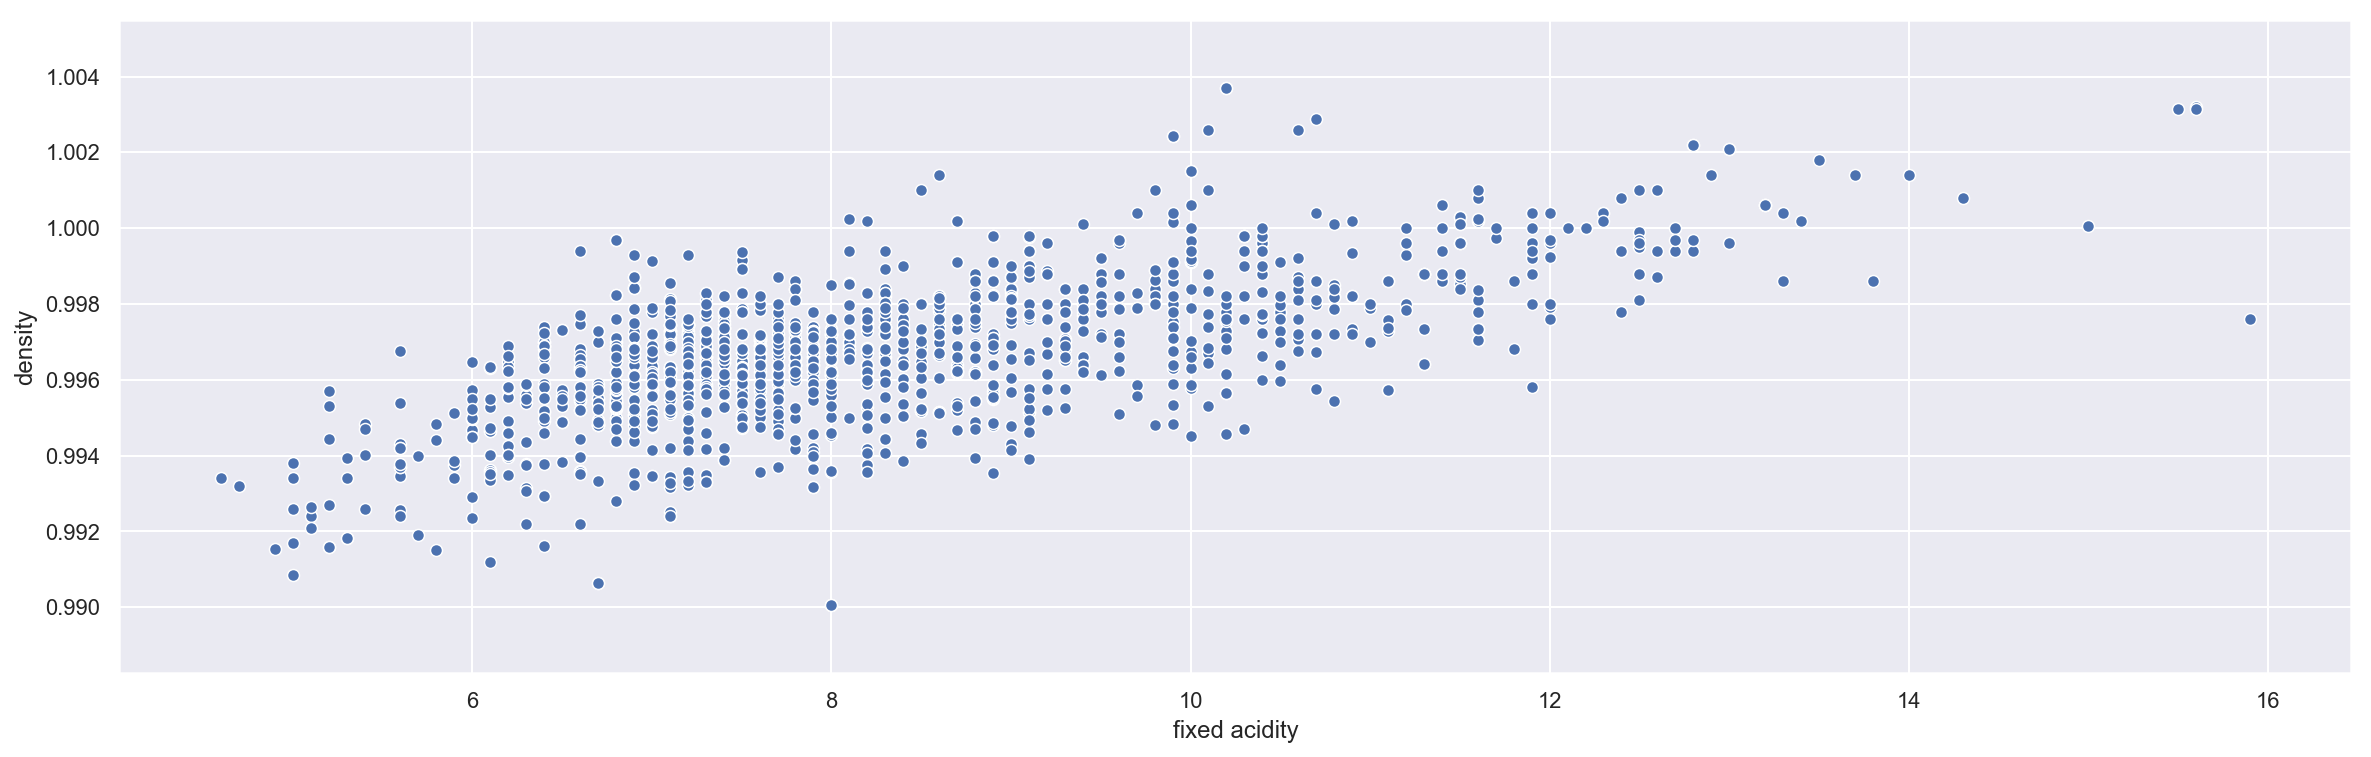

In [45]:
plt.figure(figsize=(20,6))
sns.scatterplot(x='fixed acidity', y='density', data=df_modelar)
plt.show()

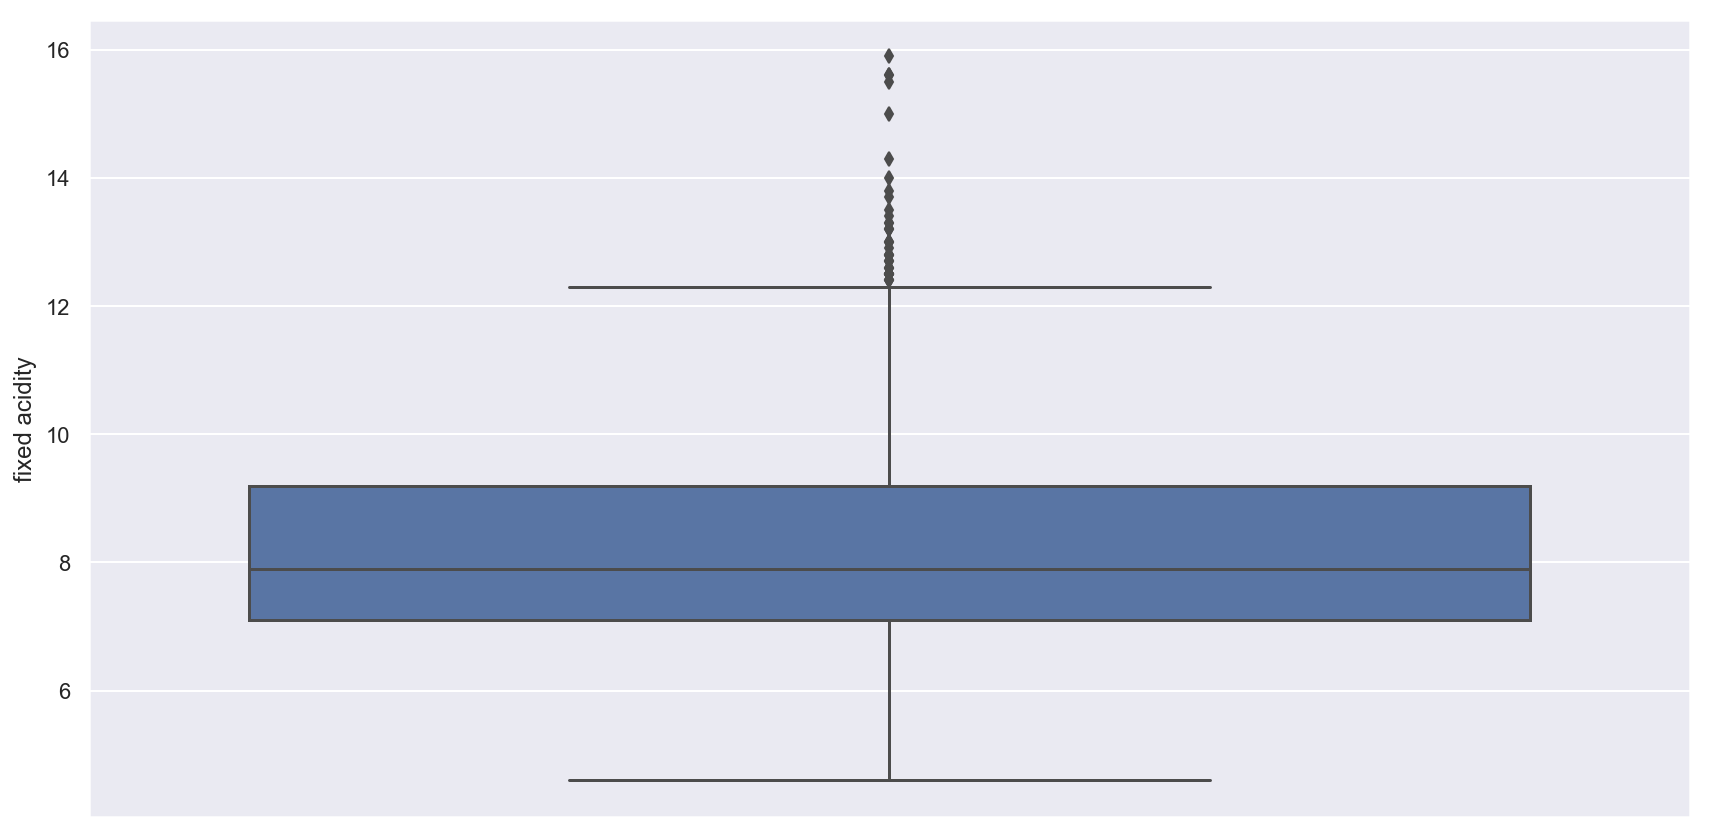

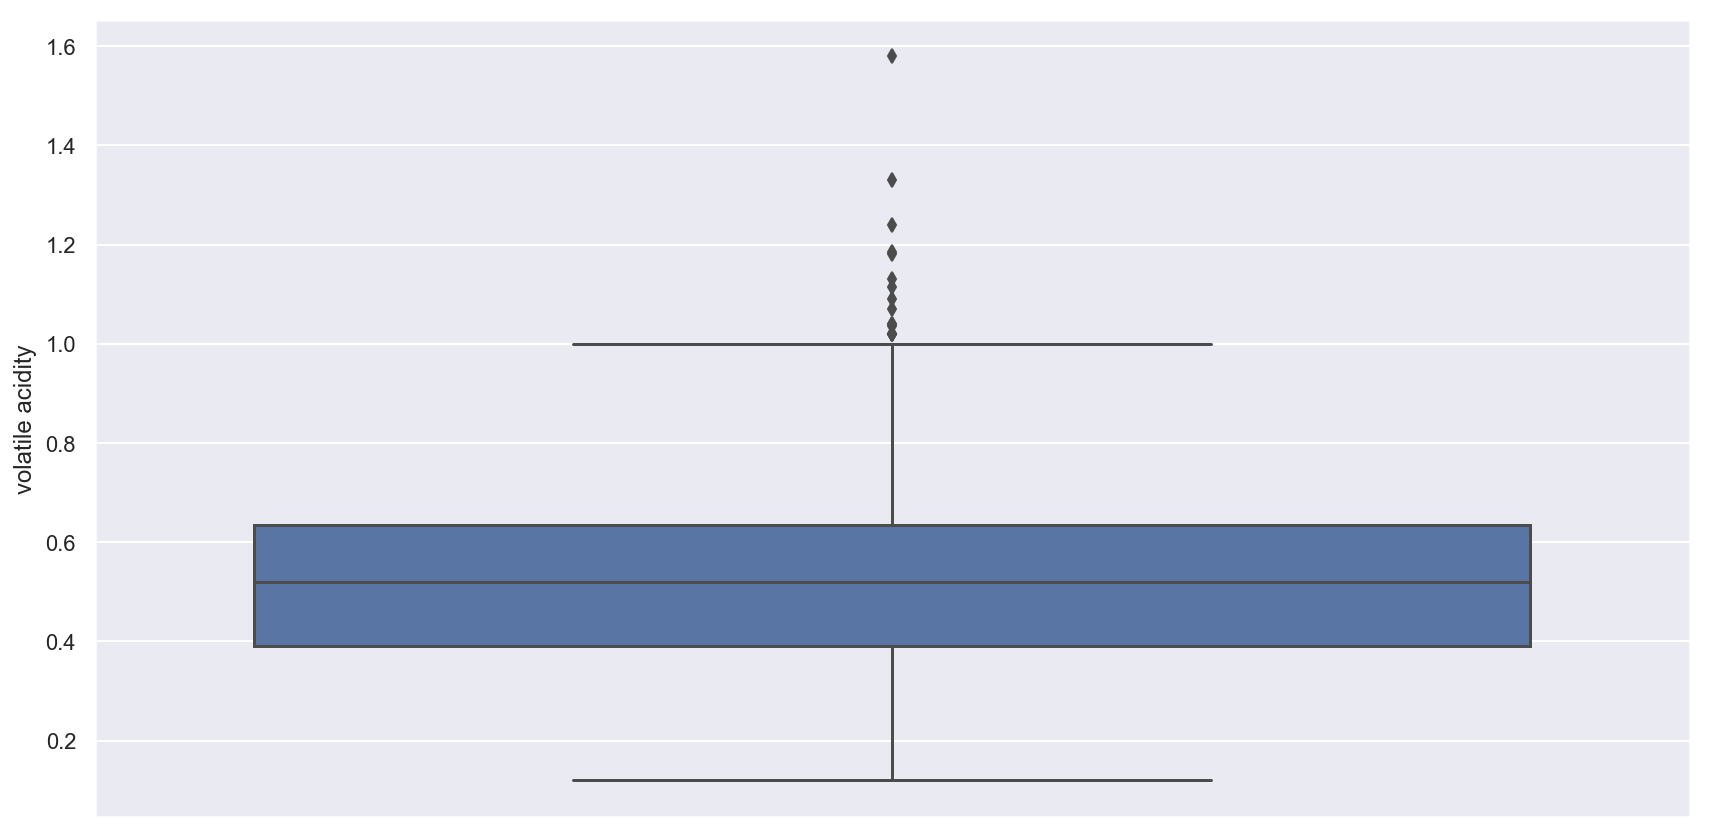

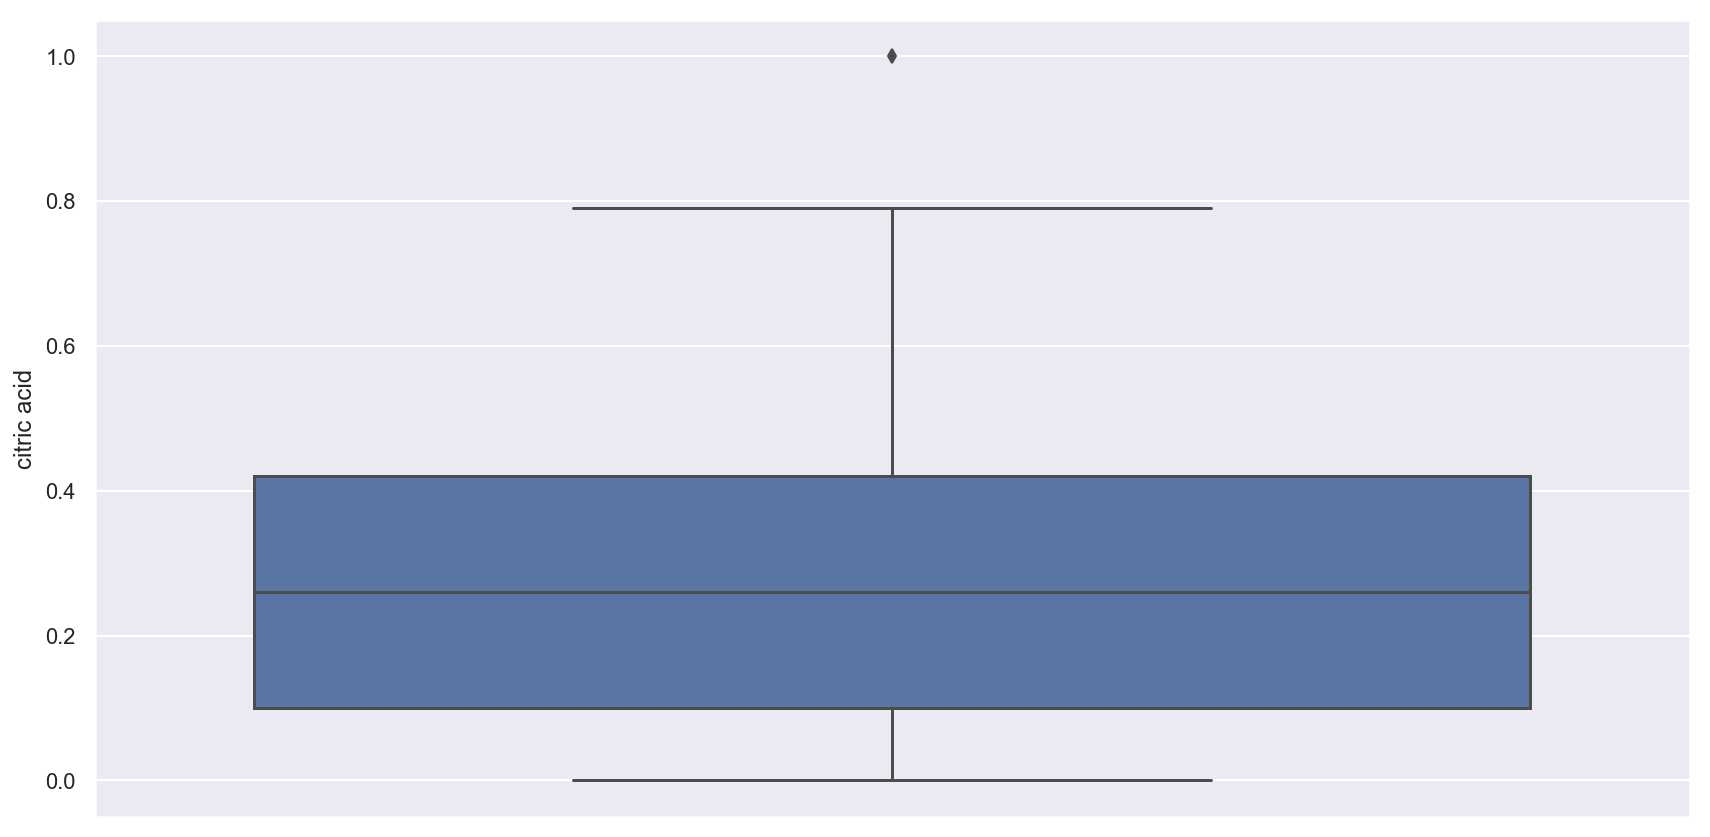

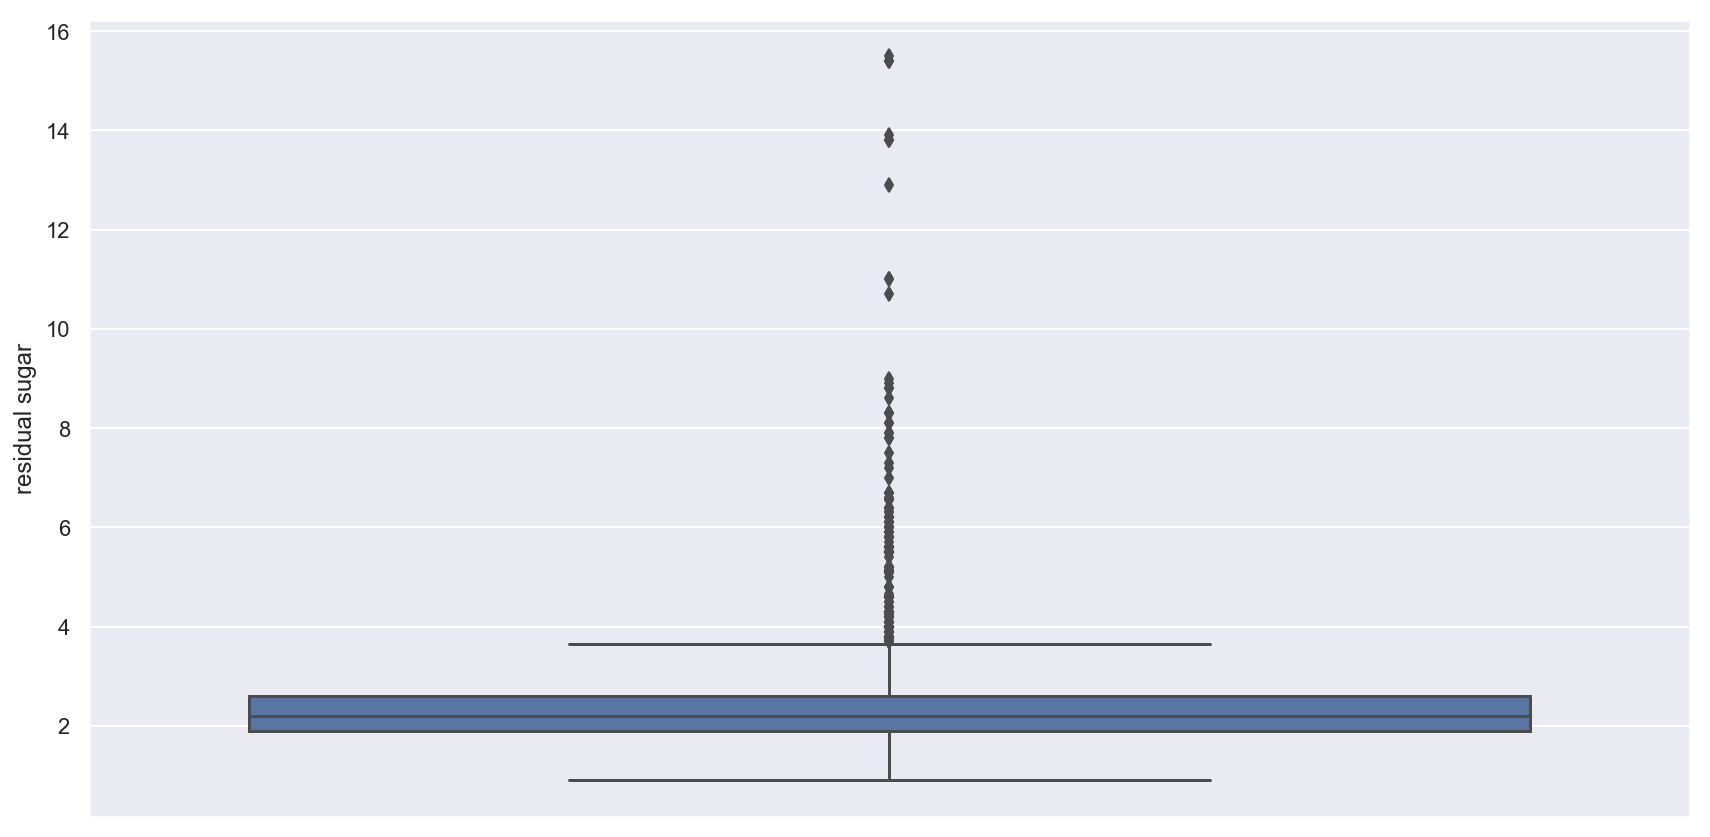

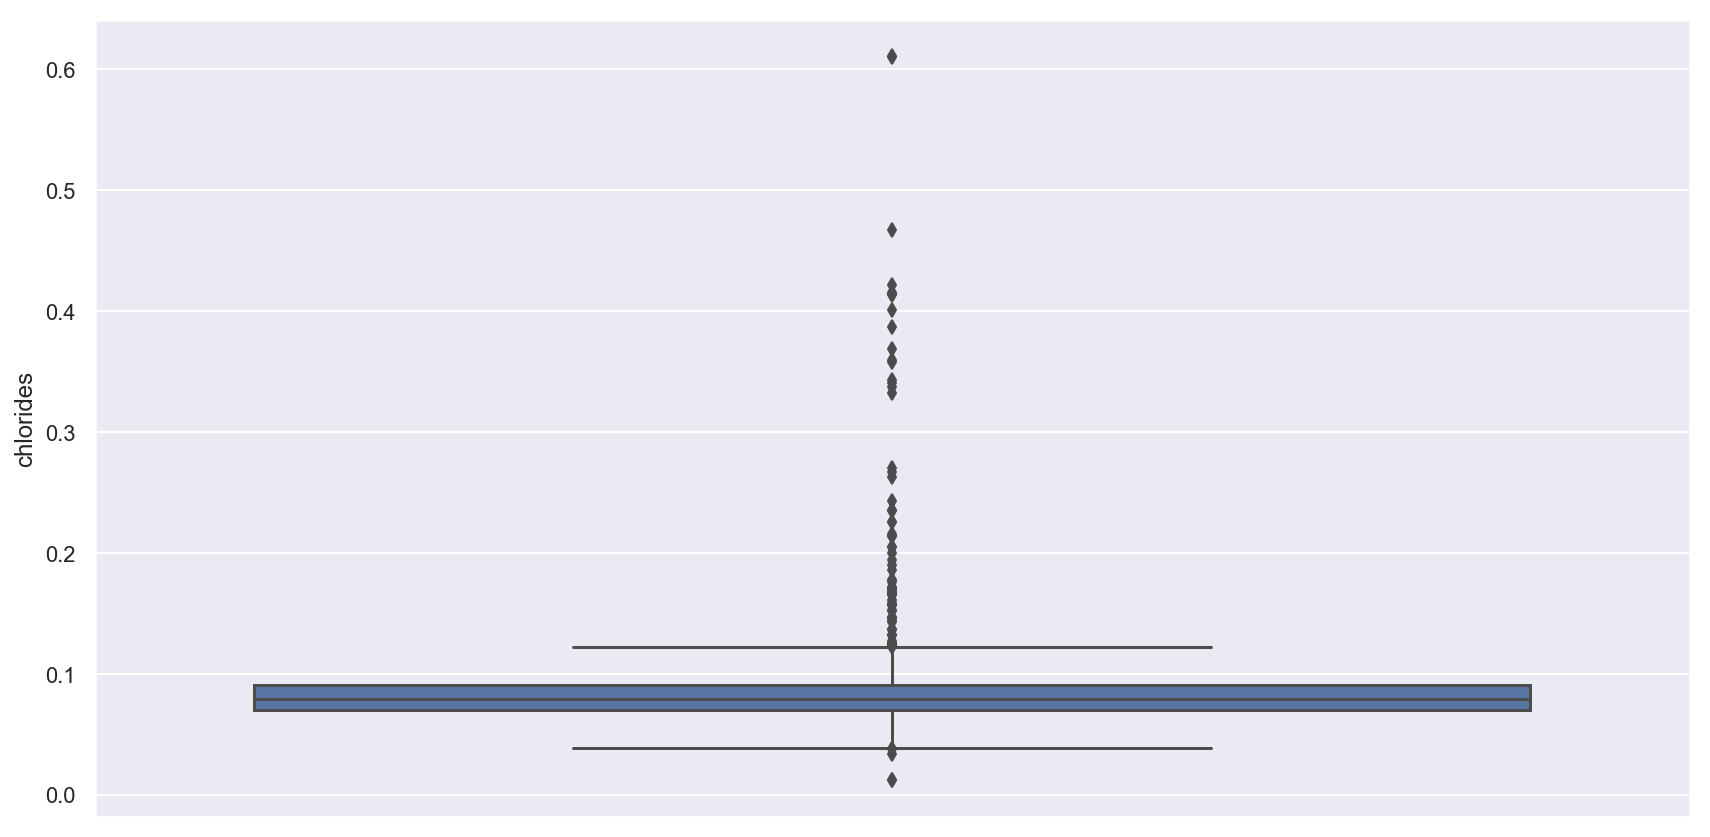

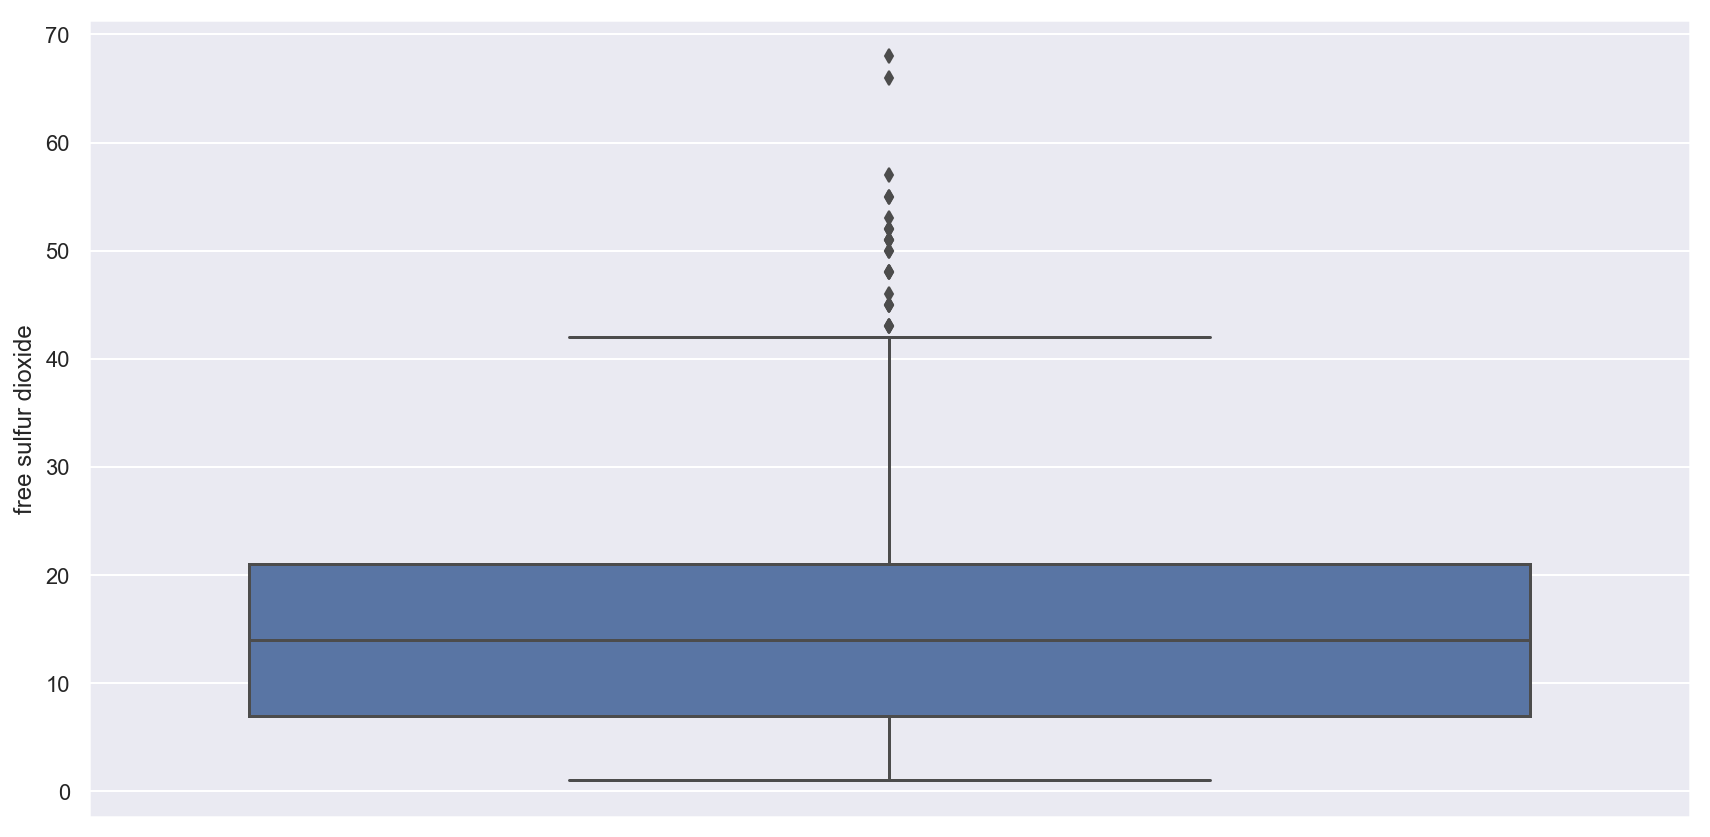

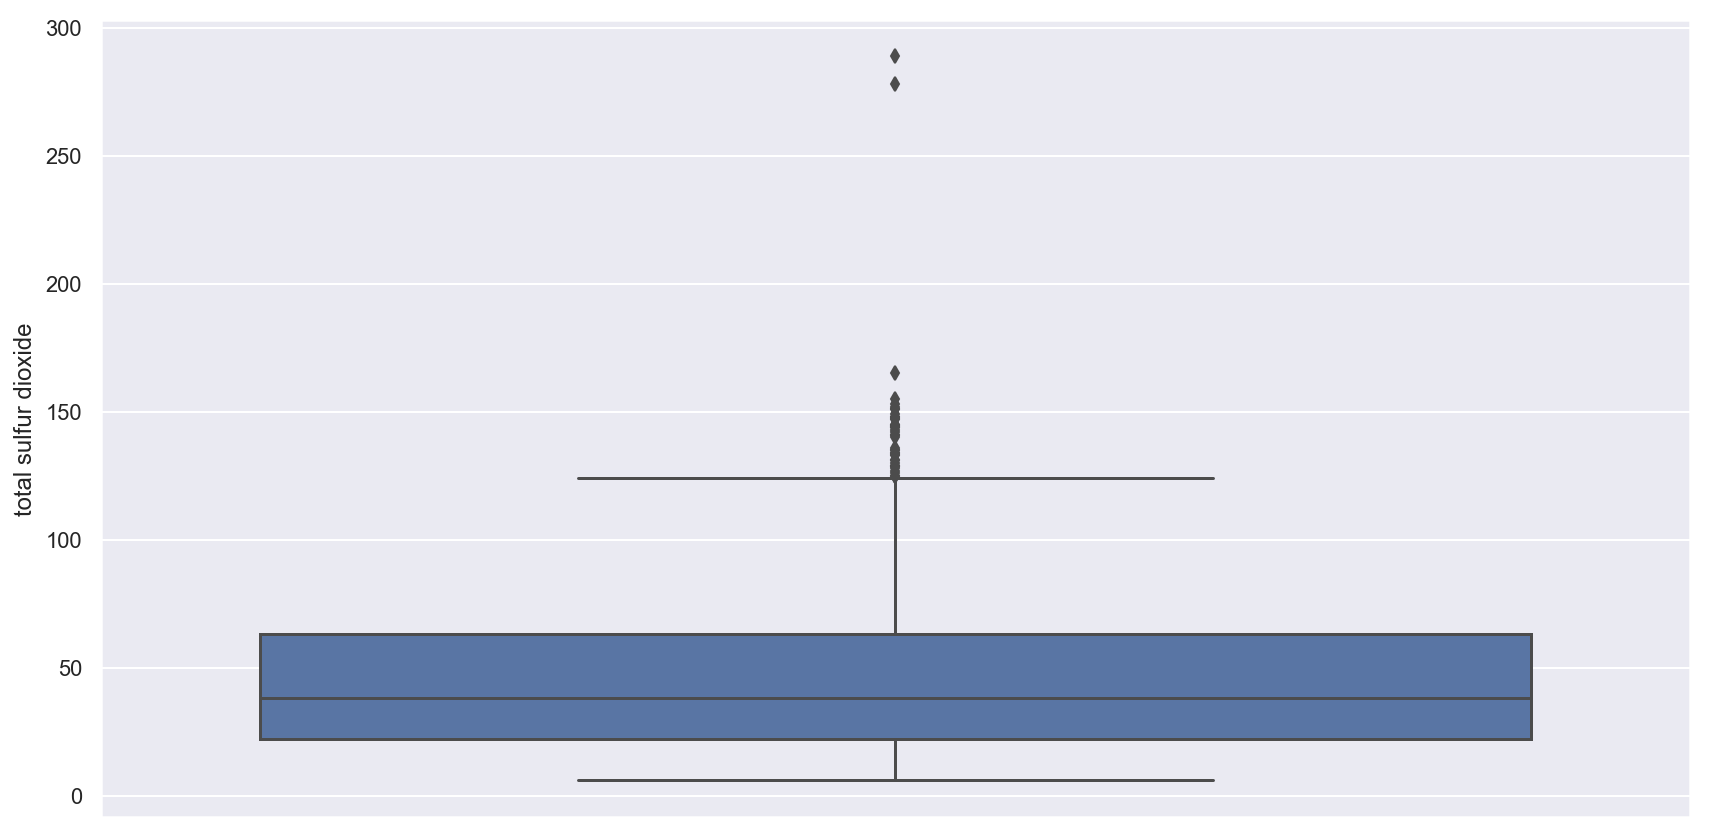

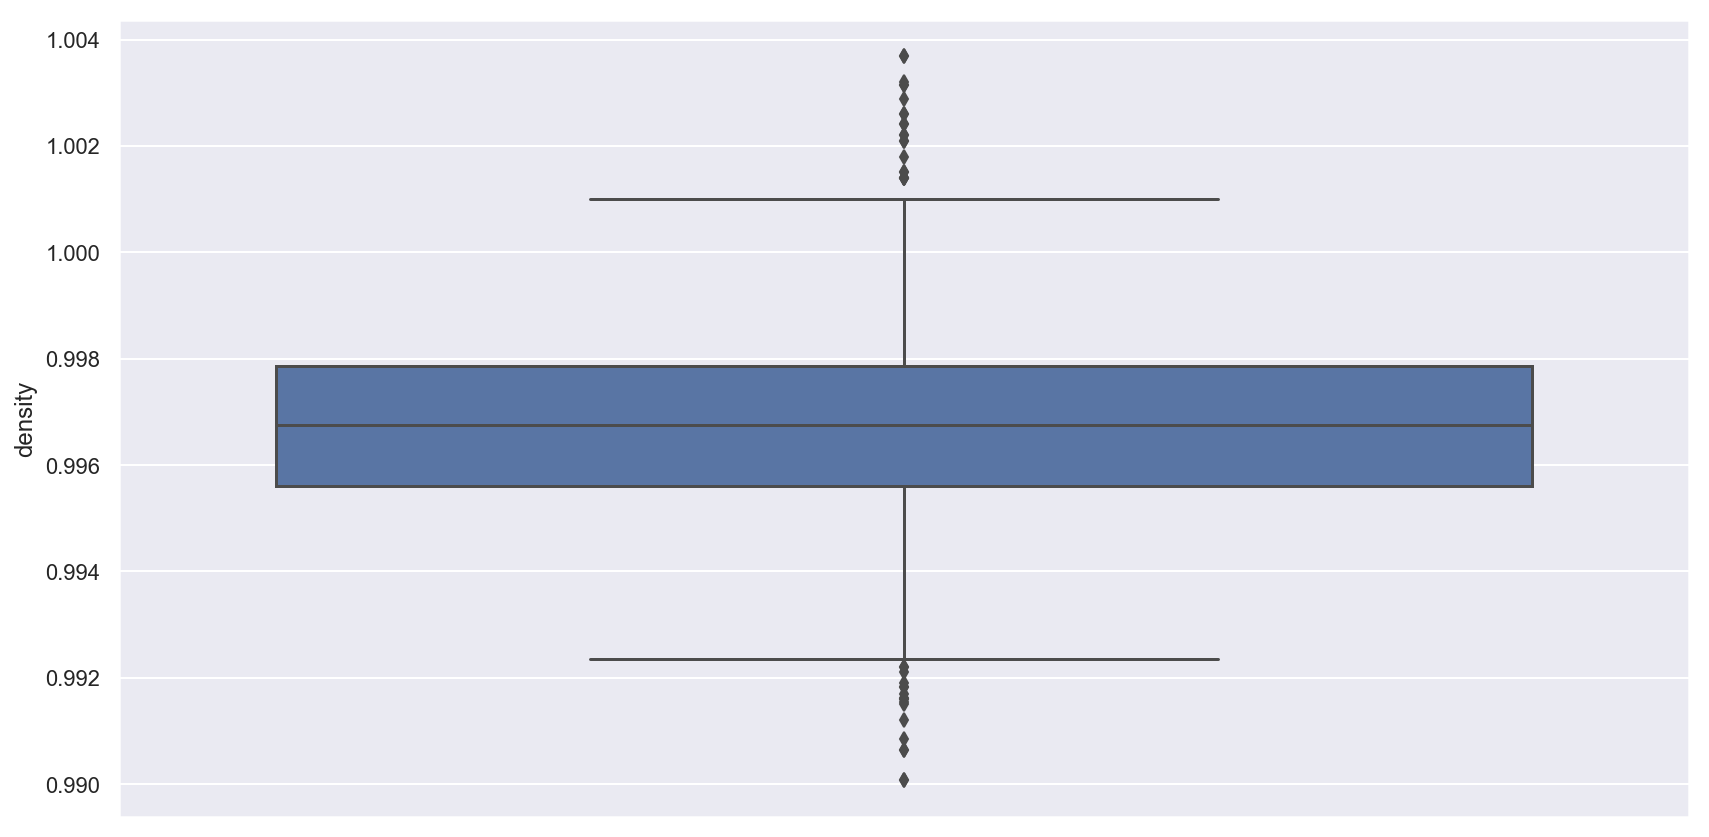

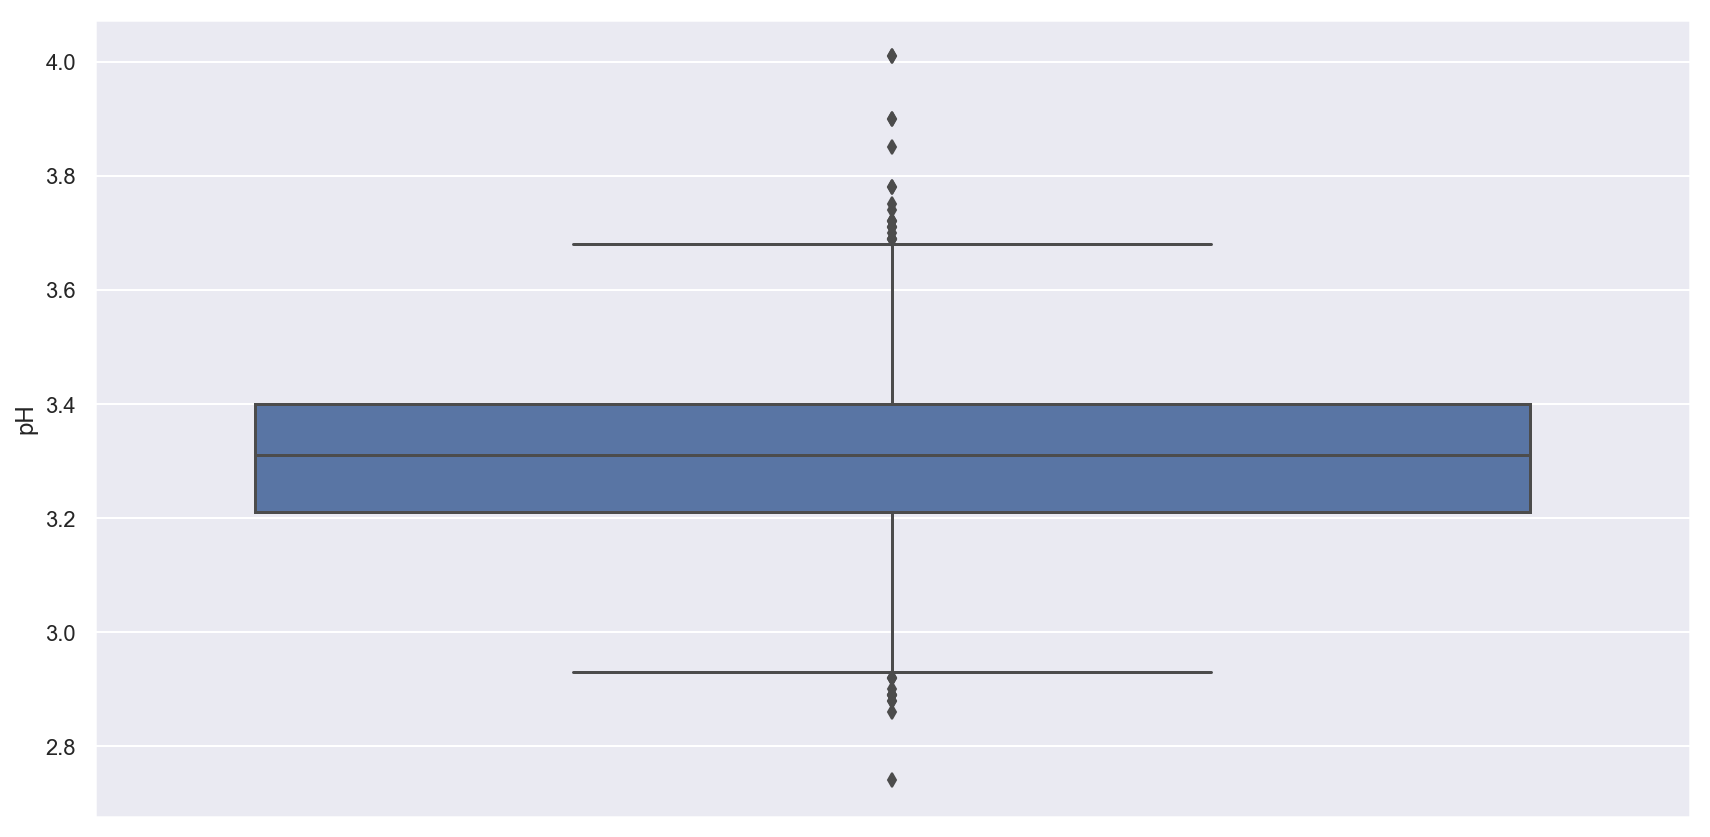

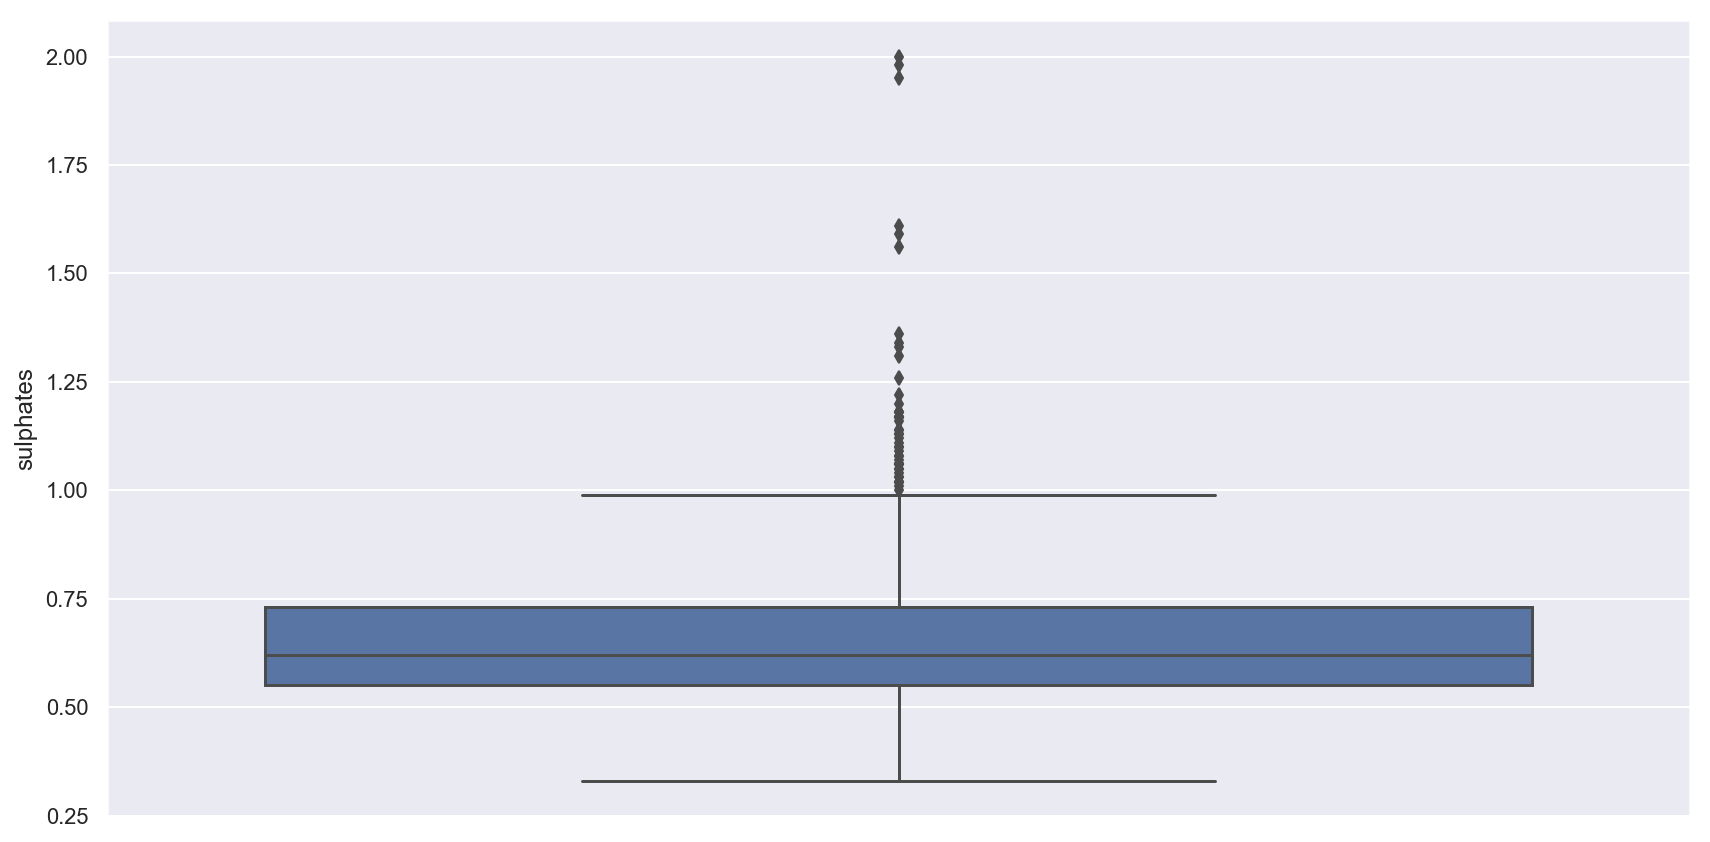

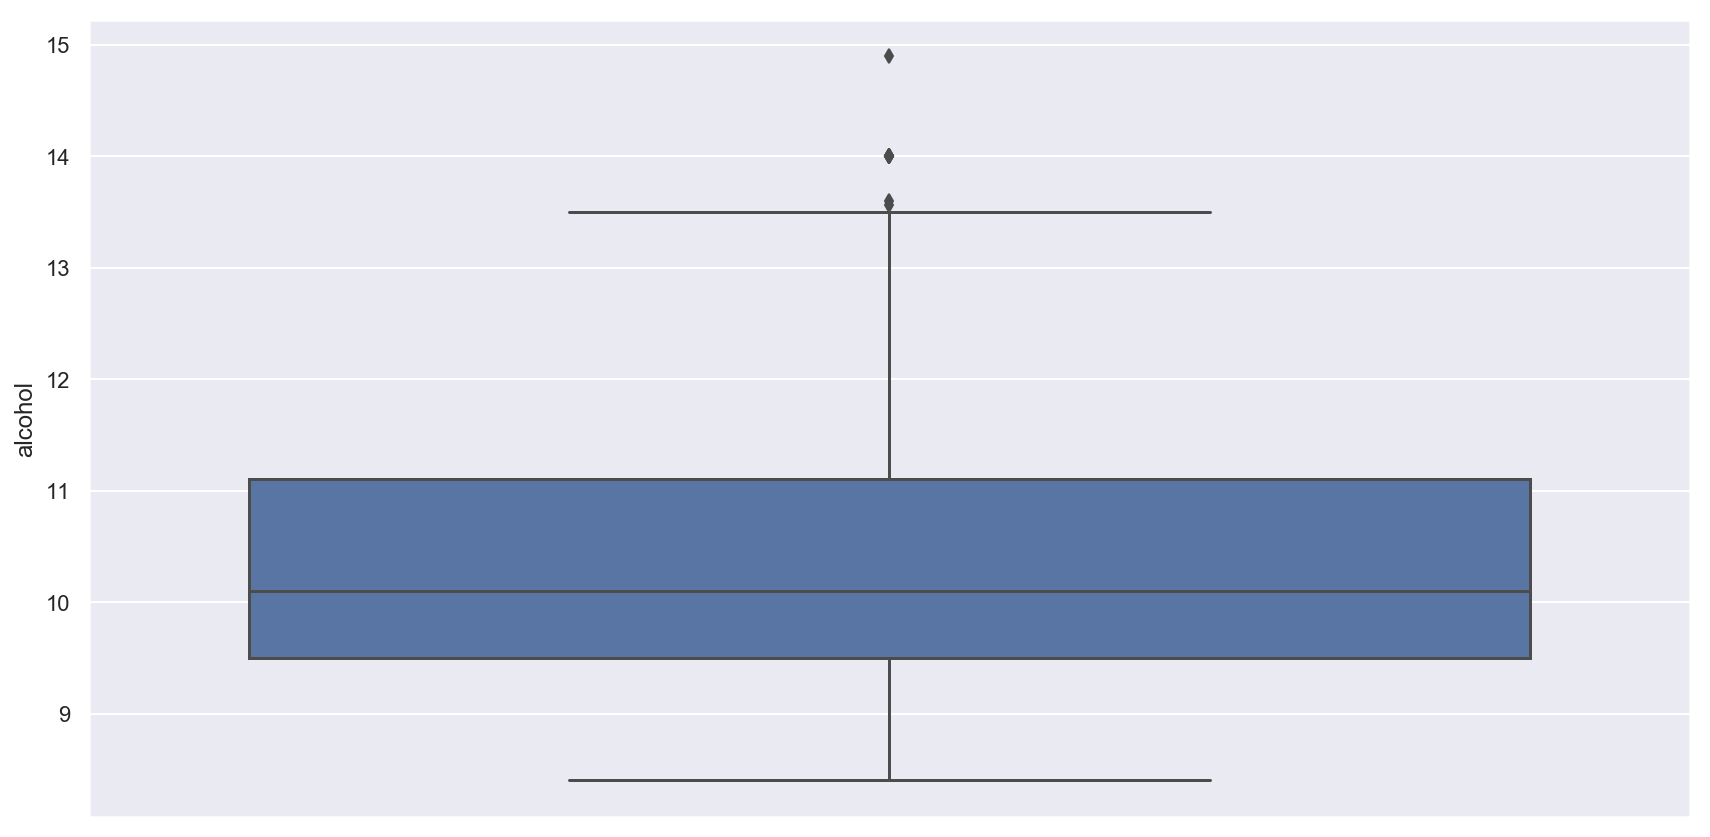

In [46]:
for c in df_modelar.columns[:-1]:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=df_modelar[c], orient='vertical')
    plt.tight_layout()
    plt.plot()

Eliminamos los posibles outliers

In [47]:
def delete_outliers(df, columns):
    df_aux = df.copy()
    for col_name in columns:
        third_quantile_area = df_aux[col_name].quantile(0.75)
        df_aux[col_name] = df_aux[df_aux[col_name] < third_quantile_area][col_name]
    return df_aux

In [48]:
df_modelar = delete_outliers(df_modelar, df_modelar.columns[:-1])

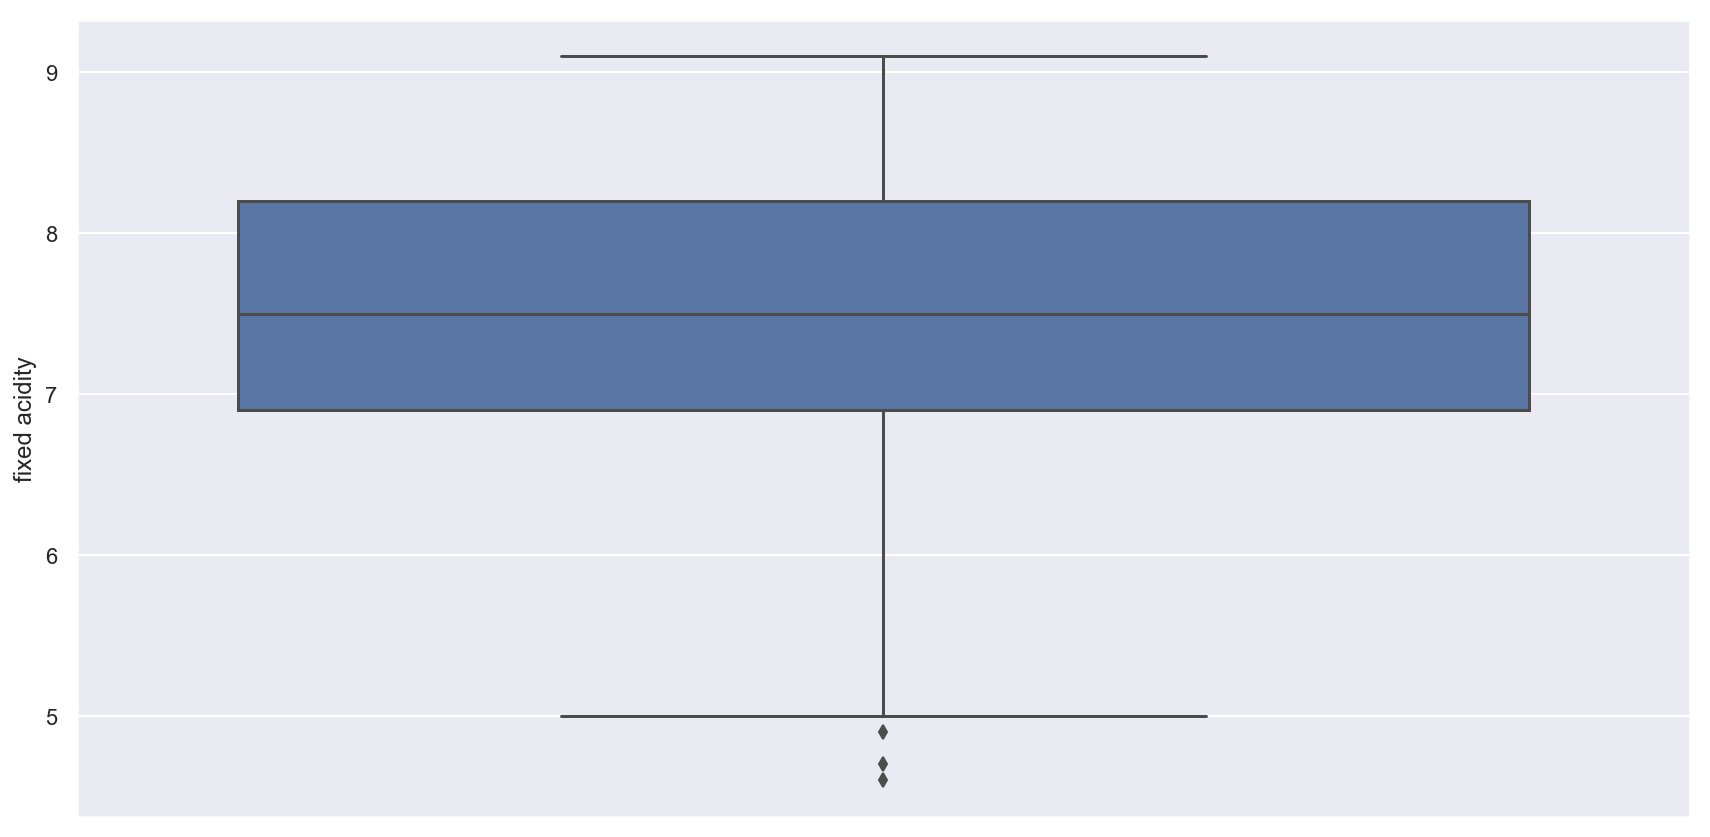

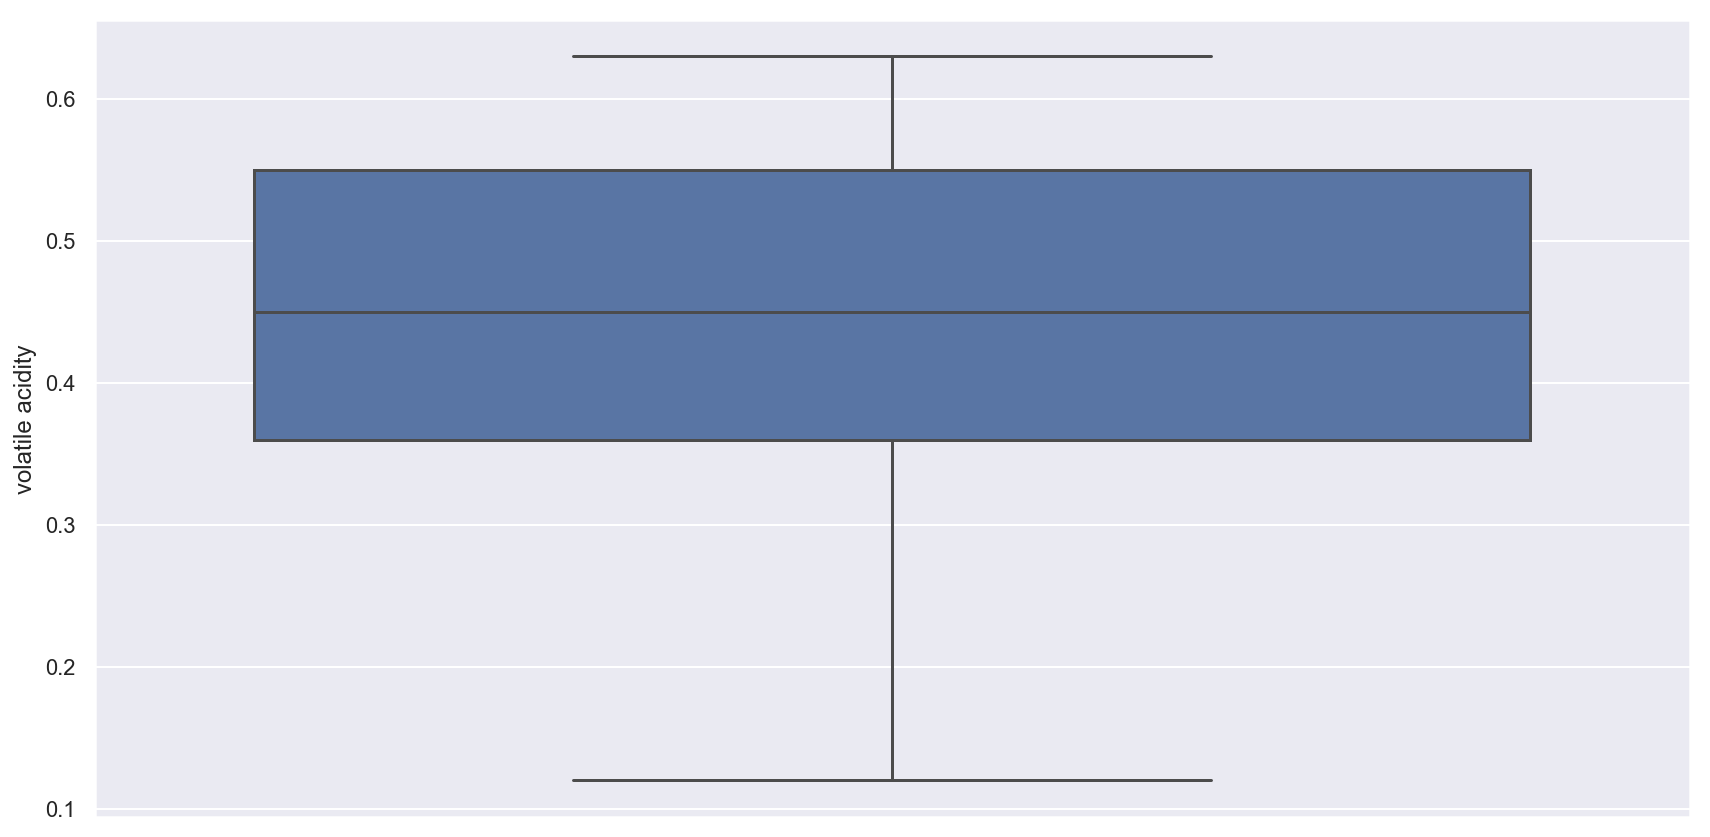

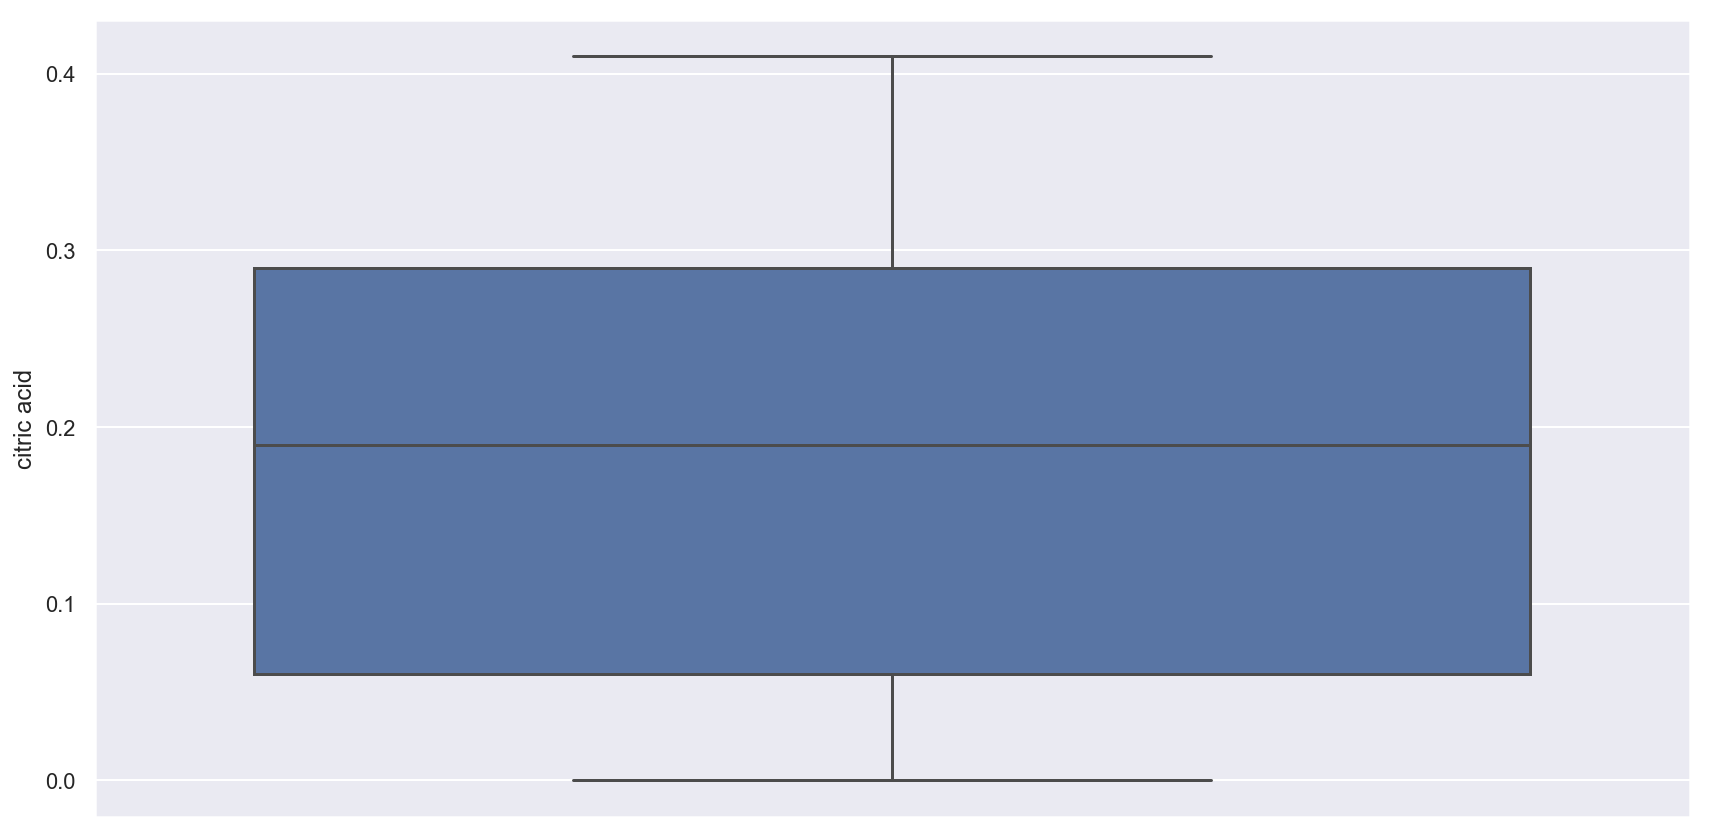

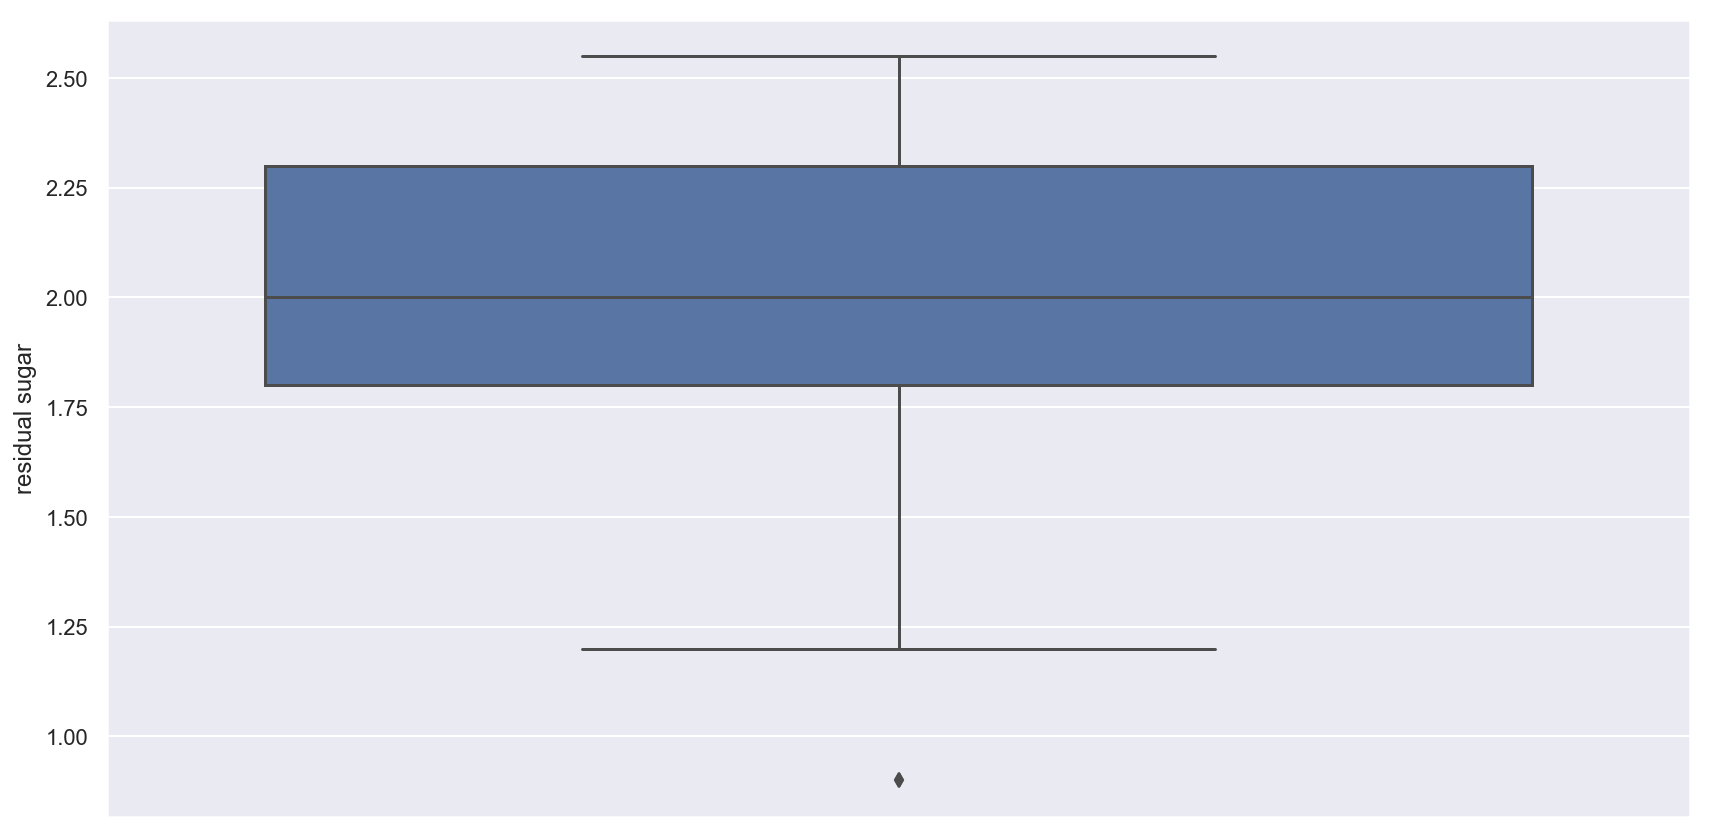

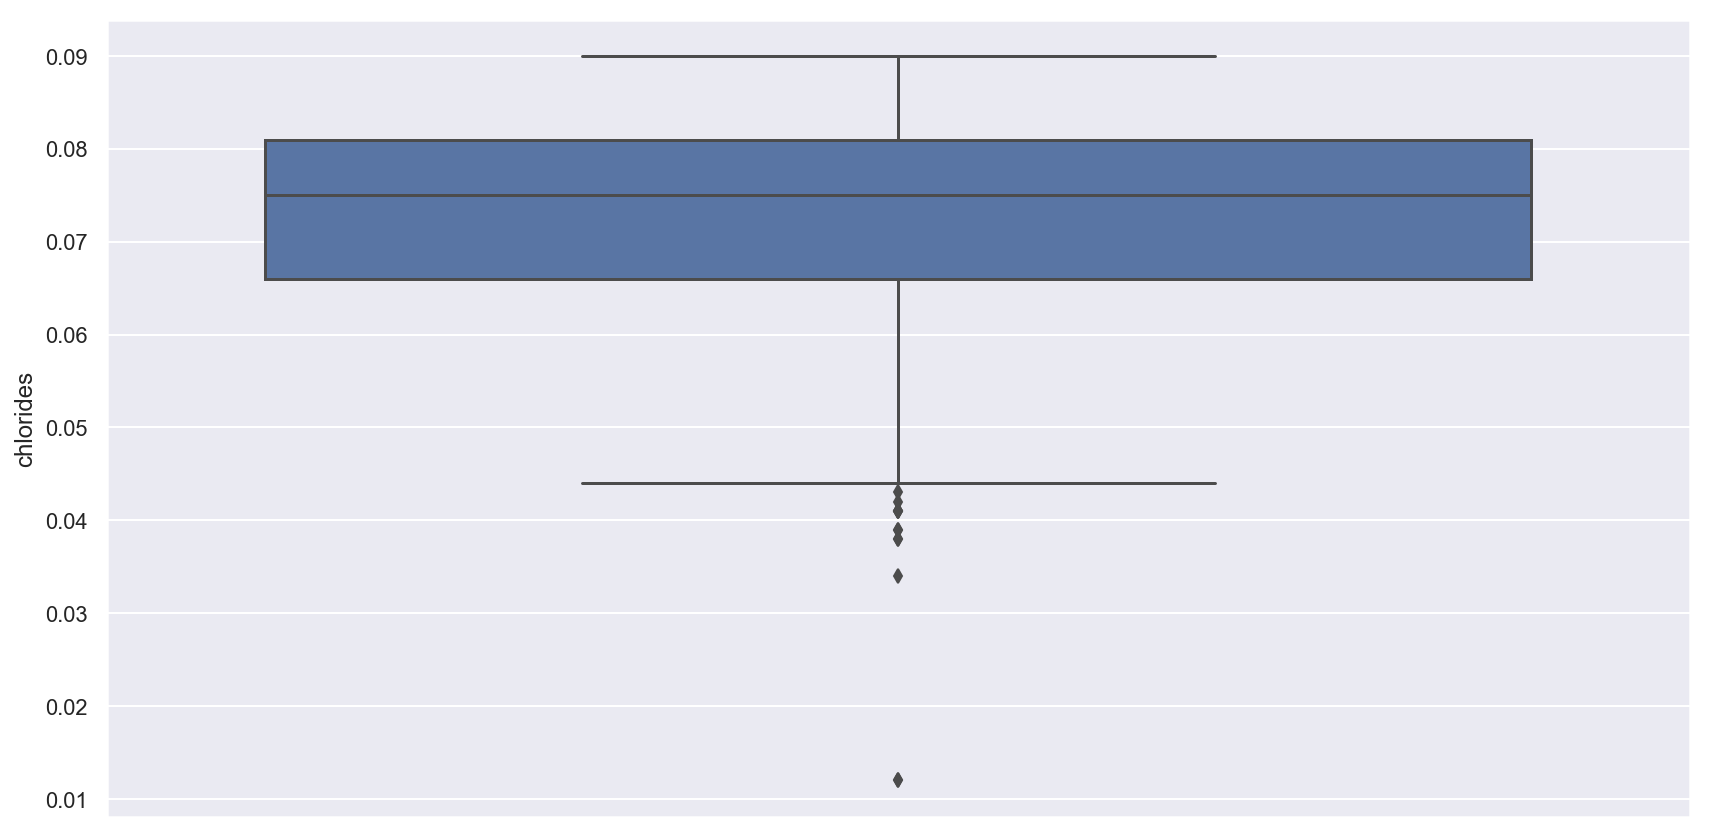

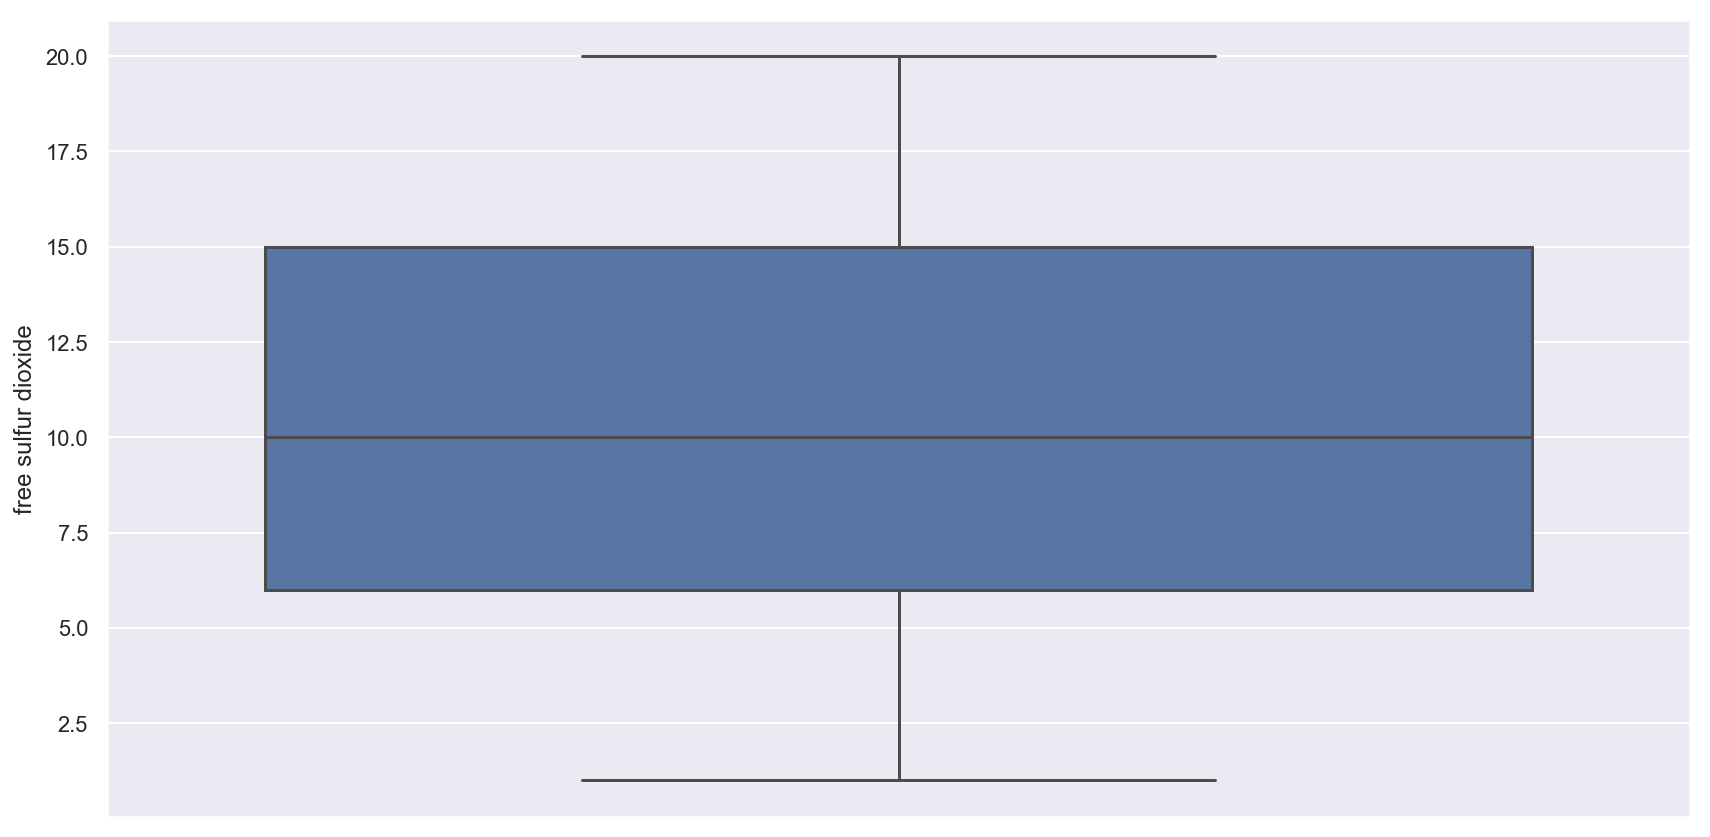

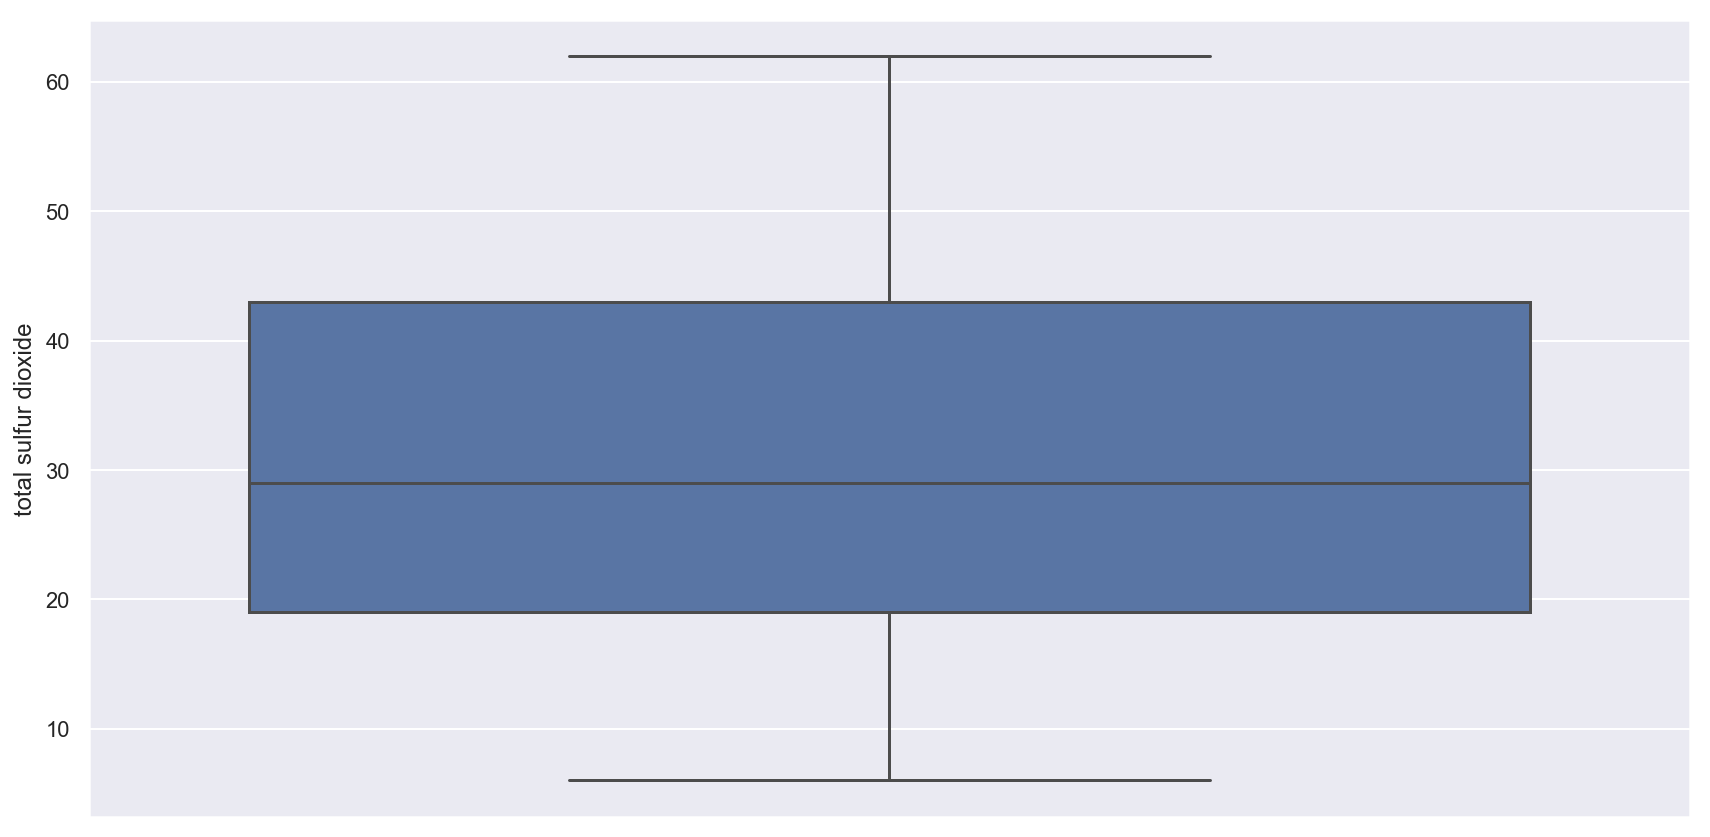

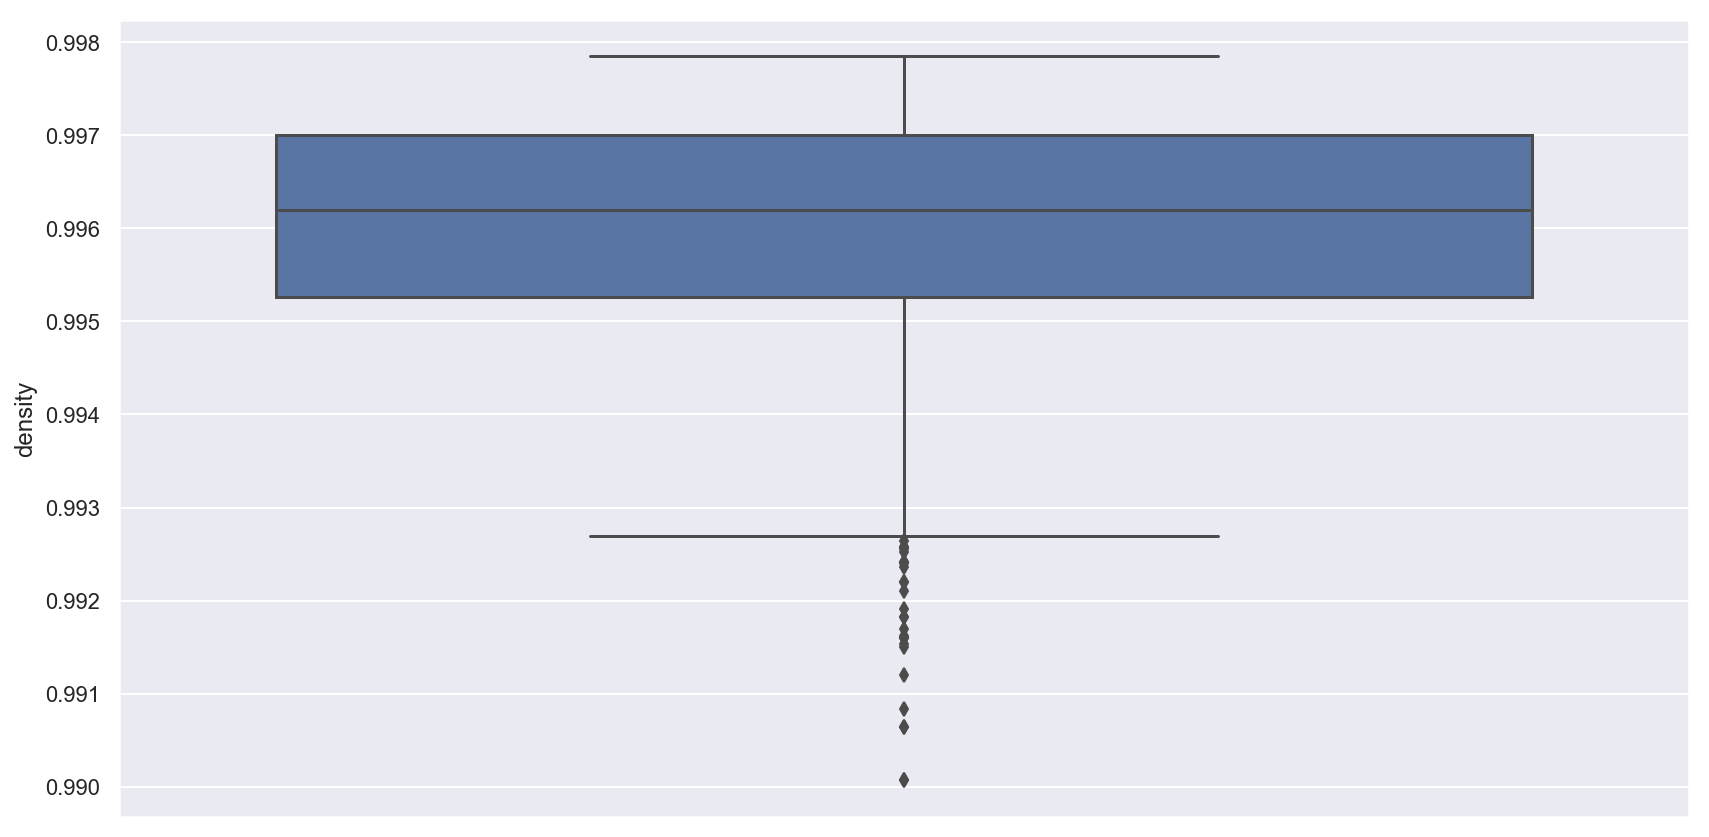

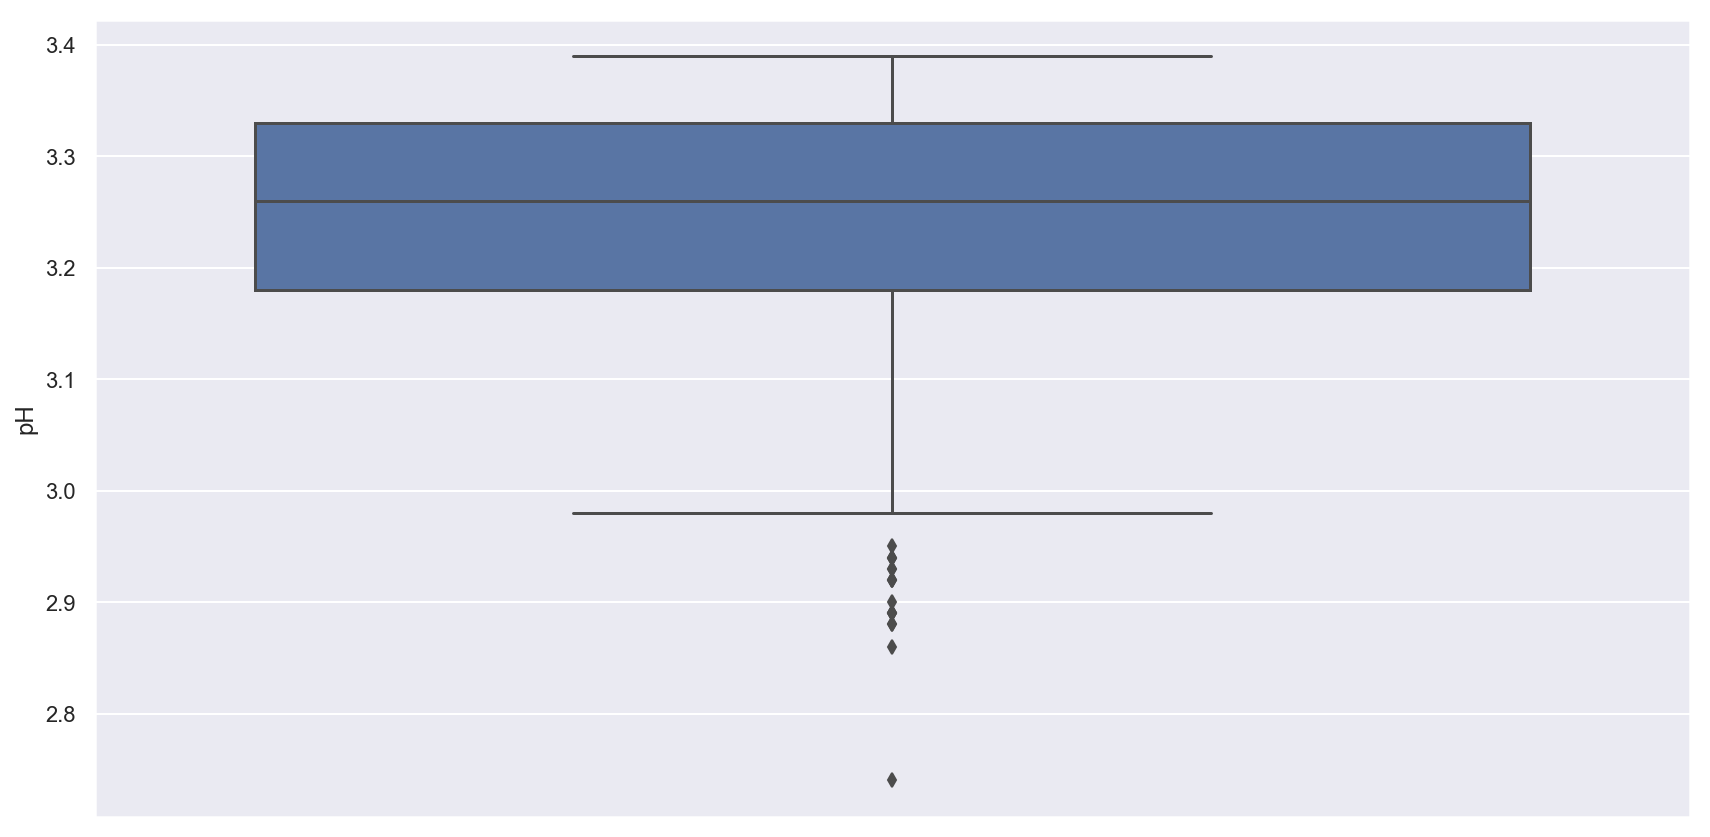

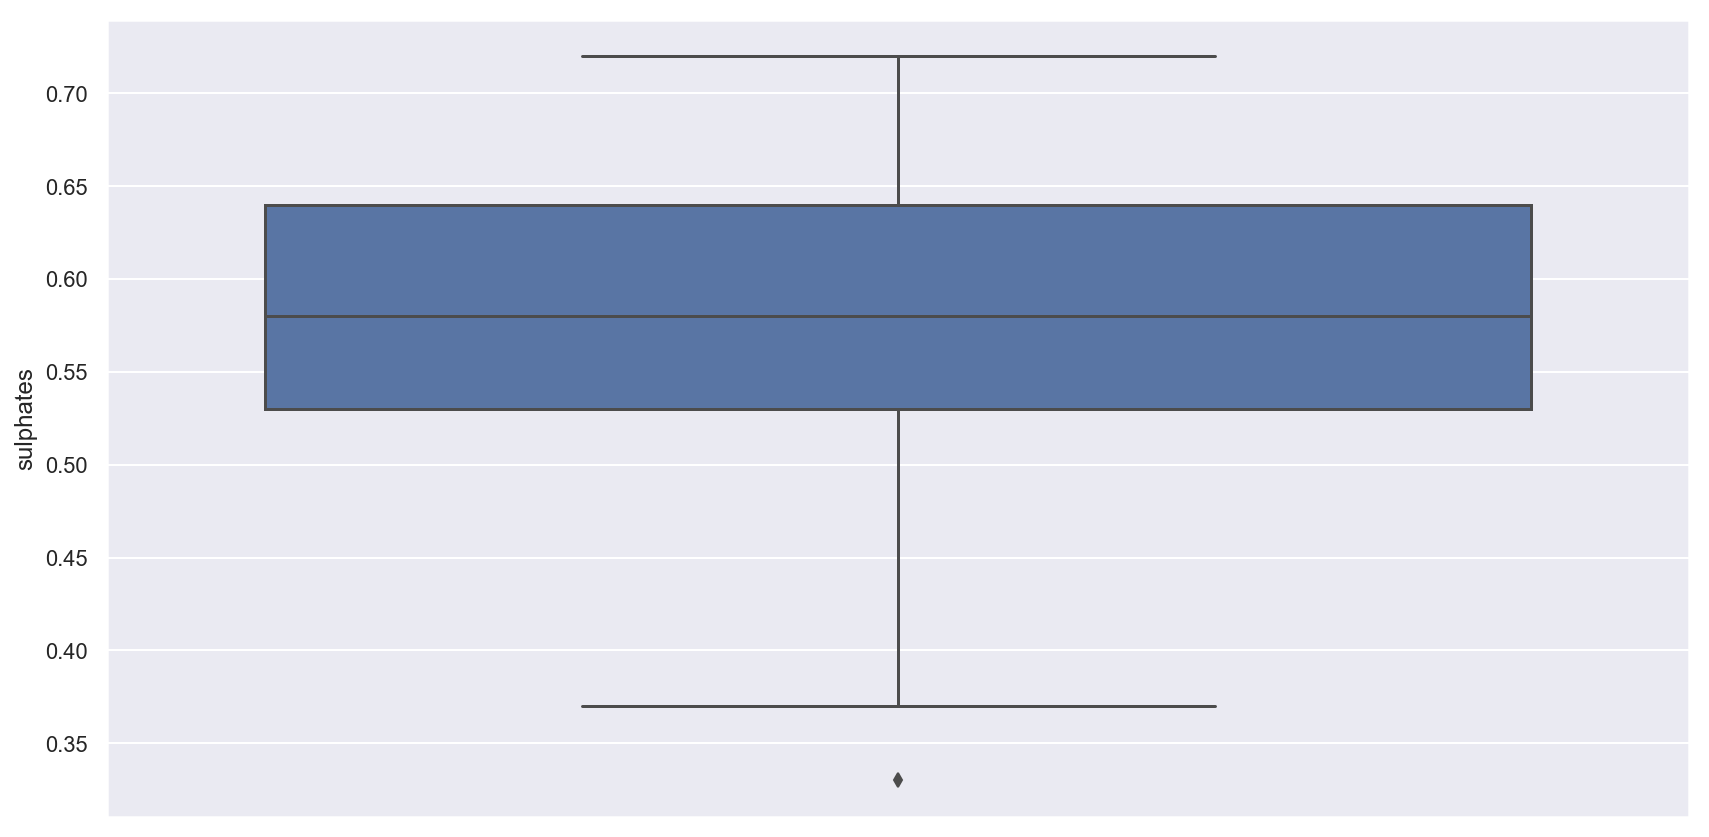

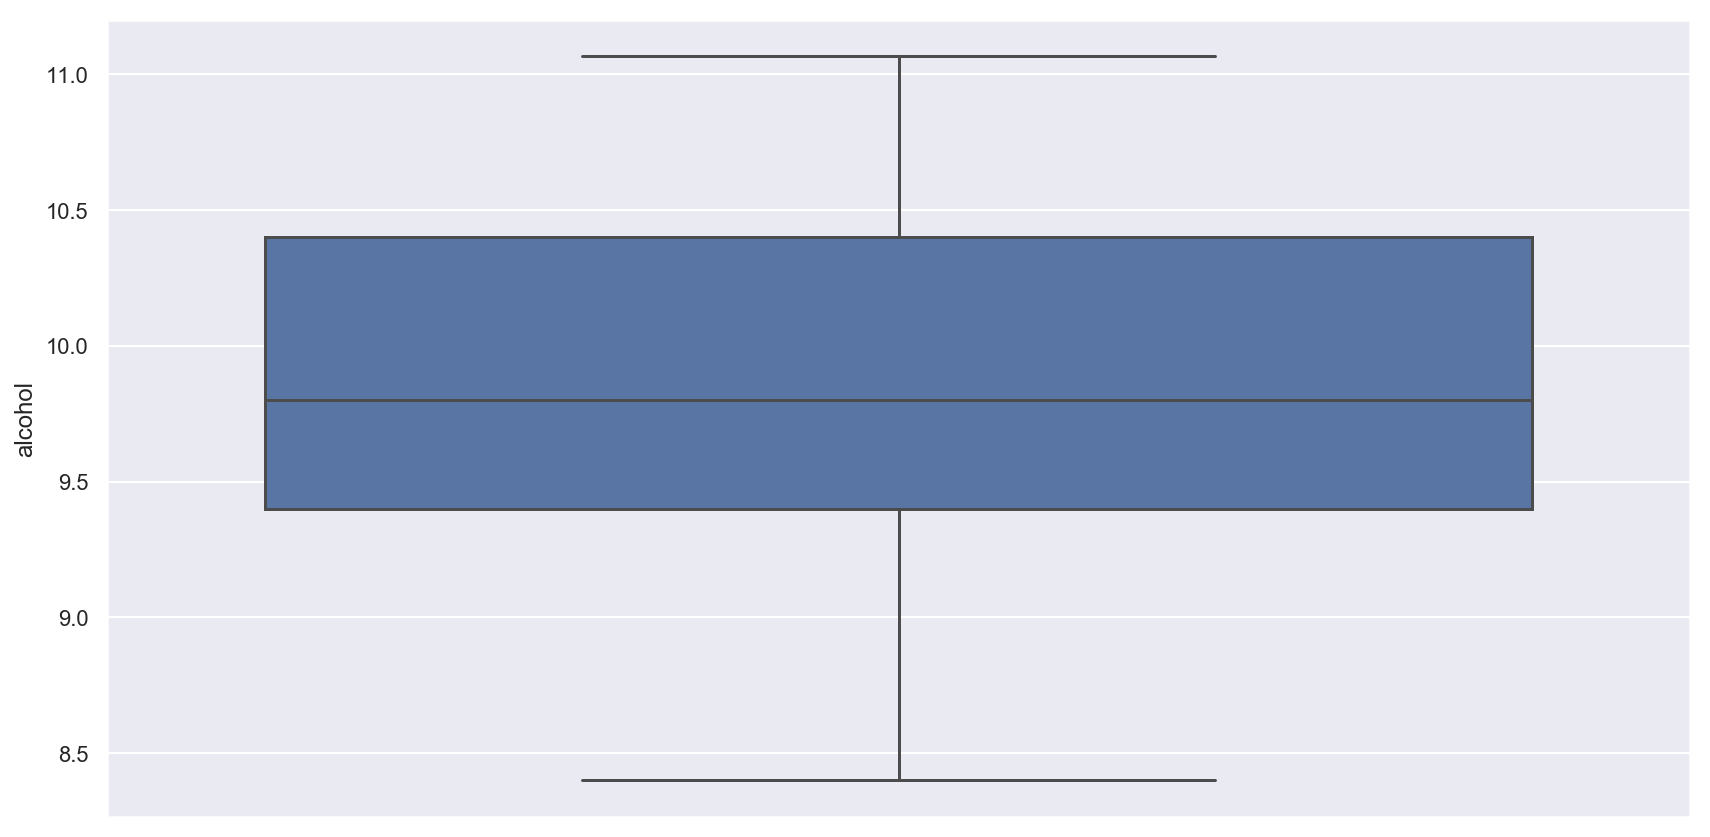

In [49]:
for c in df_modelar.columns[:-1]:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=df_modelar[c], orient='vertical')
    plt.tight_layout()
    plt.plot()

In [50]:
df_modelar.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1013.000000,1014.000000,996.000000,990.000000,1017.000000,984.000000,1017.000000,1018.000000,999.000000,1018.000000,1013.000000,1359.000000
mean,7.494472,0.447589,0.179869,2.022929,0.072992,10.664126,31.306785,0.995967,3.244124,0.583811,9.906943,5.634290
std,0.902680,0.117400,0.129716,0.298063,0.011223,4.832730,14.736073,0.001342,0.108827,0.073449,0.583174,0.808297
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,6.900000,0.360000,0.060000,1.800000,0.066000,6.000000,19.000000,0.995265,3.180000,0.530000,9.400000,5.000000
50%,7.500000,0.450000,0.190000,2.000000,0.075000,10.000000,29.000000,0.996200,3.260000,0.580000,9.800000,6.000000
75%,8.200000,0.550000,0.290000,2.300000,0.081000,15.000000,43.000000,0.997000,3.330000,0.640000,10.400000,6.000000
max,9.100000,0.630000,0.410000,2.550000,0.090000,20.000000,62.000000,0.997850,3.390000,0.720000,11.066667,8.000000


# Problema de clasificacion

#### Convertimos el problema actual en uno de clasifcacion estableciendo como buen vino aquel cuya calidad sea mayor que 6.5

In [8]:
df_classification = df.copy()
df_classification['quality'] = df_classification['quality'].apply(lambda x: 'good' if x > 6.5 else 'bad')
df_classification.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,bad
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


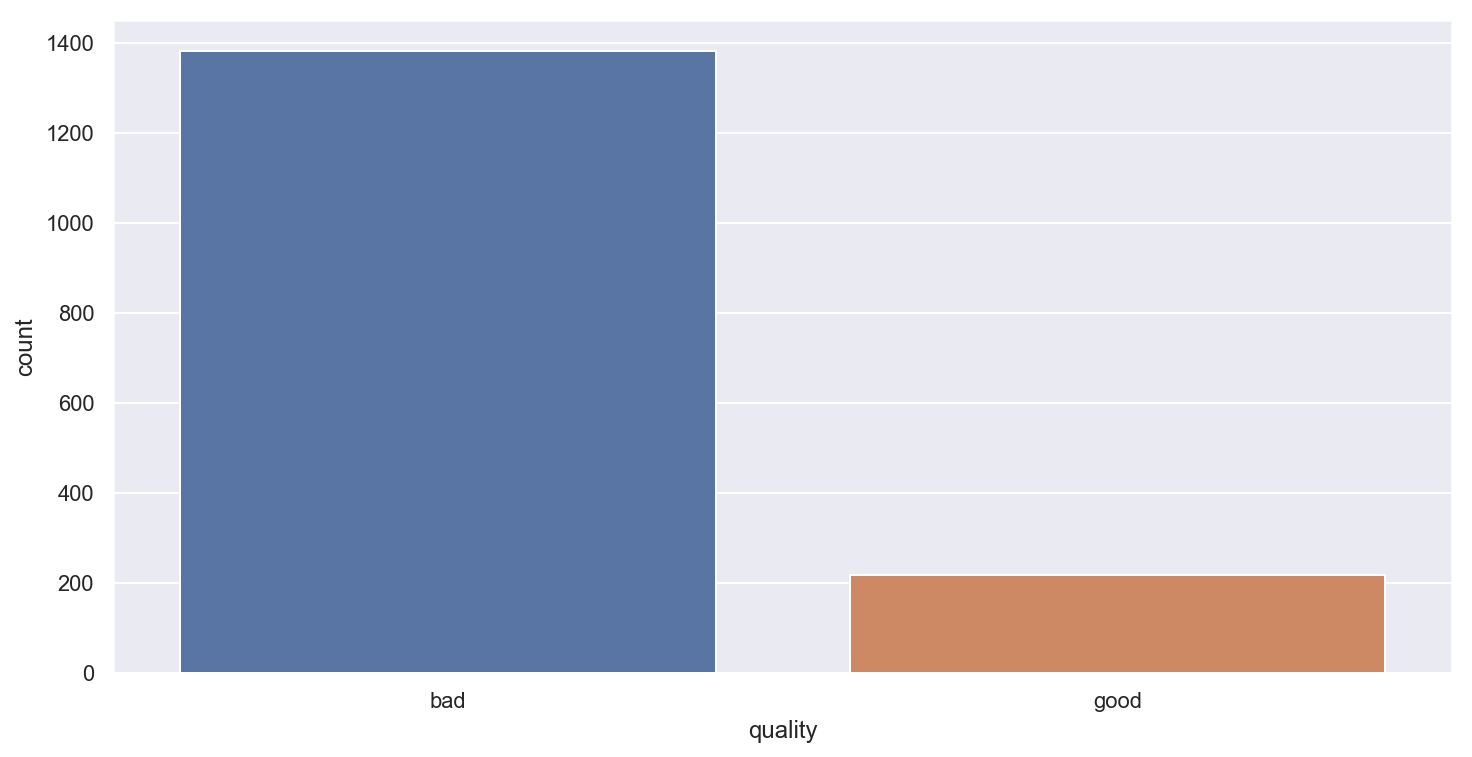

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(df_classification['quality'])
plt.show()

In [19]:
good_percentage = len(df_classification[df_classification['quality']=='good'])/len(df_classification)
bad_percentage = 1-good_percentage


print(f"Hay un {np.round(bad_percentage, 3)}% con respecto a la clase bad")
print(f"Hay un {np.round(good_percentage,3)}% con respecto a la clase good")

Hay un 0.864% con respecto a la clase bad
Hay un 0.136% con respecto a la clase good
